# Forecast User Movement

## I. Import Dependencies
---

In [74]:
# import numpy for math calculations
import numpy as np

# Import pandas for data (csv) manipulation
import pandas as pd

# Import matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('fivethirtyeight') 
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# import seaborn for more plotting options(built on top of matplotlib)
import seaborn as sns

# Import pytorch to build Deel Learling Models 
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import models
from torch.nn import functional as F
import torch.utils.data
from torchvision.models.inception import inception_v3
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from tqdm import tqdm
from sklearn.metrics import mean_squared_error

# Import tqdm to show a smart progress meter
from tqdm import tqdm_notebook

# Import warnings to hide the unnessairy warniings
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
######################################
### Configurations 
######################################

WINDOW_SIZE = 300
INPUT_SIZE = 18
OUTPUT_SIZE = 3
BATCH_SIZE = 16
HIDDEN_SIZE = 64
DROPOUT = 0.1
FORECAST_HORIZON = 120

## II. Data Preparation
---

In [76]:
data = pd.read_csv("/kaggle/input/random-user/group1_order2_user5_fast_movement.csv")

In [77]:
data.head()

TouchButtons  LeftIndexTrigger  RightIndexTrigger  LeftHandTrigger  \
0             0               0.0                0.0         0.000000   
1             0               0.0                0.0         0.011233   
2             0               0.0                0.0         0.022711   
3             0               0.0                0.0         0.025153   
4             0               0.0                0.0         0.024420   

   RightHandTrigger  LeftTouchPosX  LeftTouchPosY  LeftTouchPosZ  \
0               0.0       0.493245       0.945202      -0.259537   
1               0.0       0.492411       0.930874      -0.256664   
2               0.0       0.491576       0.917751      -0.253671   
3               0.0       0.490771       0.904356      -0.250177   
4               0.0       0.490154       0.893497      -0.246911   

   LeftTouchOrientationW  LeftTouchOrientationX  ...  RightTouchOrientationY  \
0               0.840181              -0.292592  ...               -0.564745   
1               0.836653              -0.309839  ...               -0.564225   
2               0.833256              -0.324965  ...               -0.562472   
3               0.829161              -0.339847  ...               -0.558376   
4               0.824978              -0.352392  ...               -0.551029   

   RightTouchOrientationZ  HeadPosX  HeadPosY  HeadPosZ  HeadOrientationW  \
0               -0.235621  0.401124   1.39477 -0.068615          0.817793   
1               -0.241009  0.402402   1.39435 -0.068938          0.818372   
2               -0.248095  0.403555   1.39398 -0.069229          0.818949   
3               -0.255537  0.404760   1.39352 -0.069636          0.819610   
4               -0.259901  0.405684   1.39318 -0.069937          0.820121   

   HeadOrientationX  HeadOrientationY  HeadOrientationZ   time  
0          0.003876         -0.575346         -0.013294  0.000  
1          0.001476         -0.574507         -0.014341  0.016  
2         -0.000539         -0.573657         -0.015499  0.032  
3         -0.002548         -0.572660         -0.017119  0.049  
4         -0.003879         -0.571876         -0.018566  0.066  

[5 rows x 27 columns]

In [78]:
data['HeadPos'] = np.sqrt(data['HeadPosX']**2 + data['HeadPosY']**2 + data['HeadPosZ']**2)
data['RightHandPos'] = np.sqrt(data['RightTouchPosX']**2 + data['RightTouchPosY']**2 + data['RightTouchPosZ']**2)
data['LeftHandPos'] = np.sqrt(data['LeftTouchPosX']**2 + data['LeftTouchPosY']**2 + data['LeftTouchPosZ']**2)

Labels = ['HeadPos', 'RightHandPos', 'LeftHandPos']
Features = ['TouchButtons', 'LeftIndexTrigger', 'RightIndexTrigger',
       'LeftHandTrigger', 'RightHandTrigger', 'LeftTouchOrientationW', 'LeftTouchOrientationX',
       'LeftTouchOrientationY', 'LeftTouchOrientationZ', 'RightTouchOrientationW',
       'RightTouchOrientationX', 'RightTouchOrientationY',
       'RightTouchOrientationZ', 'HeadOrientationW', 'HeadOrientationX', 'HeadOrientationY',
       'HeadOrientationZ', 'time']
data = data.drop(columns = ['HeadPosX','HeadPosY', 'HeadPosZ', 'RightTouchPosX', 'RightTouchPosY', 'RightTouchPosZ', 'LeftTouchPosX', 'LeftTouchPosY', 'LeftTouchPosZ' ])

In [79]:
class DataGenerator(Dataset):
    def __init__(self, dataset, labels, window_size=600, forecast_horizon=60):
        self.data = dataset.copy()
        self.labels = labels
        self.window_size = window_size
        self.forecast_horizon = forecast_horizon
        self.length = len(self.data) - window_size - forecast_horizon + 1
    
    def __getitem__(self, index):
        start_index = index
        end_index = index + self.window_size
        features = self.data.iloc[start_index:end_index].drop(columns=self.labels).values.astype(np.float32)
        labels = self.data.iloc[end_index:end_index+self.forecast_horizon][self.labels].values.astype(np.float32)
        features_tensor = torch.tensor(features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)
        return (features_tensor, labels_tensor)
    
    def __len__(self):
        return self.length

In [80]:
def create_data_loaders(train_data, test_data, batch_size=16):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False)
    return train_loader, test_loader

In [81]:
def plot_predictions_over_time(model, device, test_loader, Labels, last_min=7200):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            predictions.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    
    predictions = np.array(predictions).reshape(-1, len(Labels))
    targets = np.array(targets).reshape(-1, len(Labels))
    
    # Get the last 2 minutes of data
    predictions = predictions[-last_min:]
    targets = targets[-last_min:]
    
    num_plots = len(Labels)
    fig, axes = plt.subplots(num_plots, 1, figsize=(20, 8 * num_plots))  # Increased figure size
    if num_plots == 1:
        axes = [axes]
    
    time_axis = np.arange(last_min) / 60  # Convert to seconds
    
    for i, label in enumerate(Labels):
        axes[i].plot(time_axis, targets[:, i], label='Actual', alpha=0.7)
        axes[i].plot(time_axis, predictions[:, i], label='Predicted', alpha=0.7)
        axes[i].set_xlabel('Time (seconds)', fontsize=12)
        axes[i].set_ylabel(label, fontsize=12)
        axes[i].set_title(f'Predictions vs Actual for {label} (Last 2 Minutes)', fontsize=14)
        axes[i].legend(fontsize=10)
        axes[i].tick_params(axis='both', which='major', labelsize=10)
        axes[i].grid(True, linestyle='--', alpha=0.7)
        
        # Set x-axis ticks to show every 15 seconds
        axes[i].set_xticks(np.arange(0, 121, 15))
        axes[i].set_xticklabels([f'{int(x)}' for x in np.arange(0, 121, 15)])
    
    plt.tight_layout()
    plt.show()

In [82]:
def preprocess_data(df, labels, window_size, forecast_horizon, train_frac=0.90, scaler_type='minmax'):
    df = df.fillna(method='ffill').fillna(method='bfill')
    
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("Invalid scaler type. Choose 'minmax' or 'standard'.")
    
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
    length = len(df)
    split = int(np.floor(train_frac * (length - forecast_horizon)))
    return df[:split], df[split:-forecast_horizon]

In [83]:
loss_criteria = nn.MSELoss()

train_DL, test_DL = preprocess_data(data, Labels, WINDOW_SIZE, FORECAST_HORIZON)

train_dataset = DataGenerator(train_DL, Labels,forecast_horizon=FORECAST_HORIZON , window_size=WINDOW_SIZE)
test_dataset = DataGenerator(test_DL, Labels,forecast_horizon=FORECAST_HORIZON , window_size=WINDOW_SIZE)

train_loader, test_loader = create_data_loaders(train_dataset, test_dataset, batch_size=BATCH_SIZE)

## III. Training Loop
---

In [84]:
def train(model, device, train_loader, optimizer, epoch, loss_criteria, display_counter=5):
    model.train()
    train_loss = 0
    if epoch % display_counter == 0:
        print(">>> Epoch:", epoch)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_loss = train_loss / (batch_idx+1)
    if epoch % display_counter == 0:
        print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

## IV. Testing Loop
---

In [85]:
from sklearn.metrics import mean_squared_error
from tabulate import tabulate
def test(model, device, test_loader, Labels, epoch, loss_criteria, display_counter=5):
    model.eval()
    test_loss = 0
    predictions = []
    target_list = []
    mse_scores = {label: [] for label in Labels}
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = loss_criteria(outputs, targets)
            test_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            target_list.extend(targets.cpu().numpy())
    
    avg_loss = test_loss / len(test_loader)
    predictions = np.array(predictions)
    targets = np.array(target_list)
    
    for i, label in enumerate(Labels):
        mse = mean_squared_error(targets[:, :, i].flatten(), predictions[:, :, i].flatten())
        mse_scores[label] = mse
    
    if epoch % display_counter == 0:
        print('Validation set: Average loss: {:.6f}'.format(avg_loss))
        table = [[label, mse] for label, mse in mse_scores.items()]
        print(tabulate(table, headers=['Label', 'Mean Squared Error'], tablefmt='fancy_grid'))
    
    return avg_loss

## V. Models Training
---

In [86]:
def training(model):
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0)
    loss_criteria = nn.MSELoss()
    epoch_nums = []
    training_loss = []
    validation_loss = []
    epochs = 20
    print('Training on', device)
    best_valid_loss = float('inf')
    patience = 5
    no_improvement_epochs = 0
    early_stopping_enabled = True
    for epoch in tqdm_notebook(range(1, epochs + 1)):
        train_loss = train(model, device, train_loader, optimizer, epoch, loss_criteria)
        val_loss = test(model, device, test_loader, Labels, epoch, loss_criteria)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(val_loss)
        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1
        if early_stopping_enabled and (no_improvement_epochs >= patience):
            print("Stopping training due to no improvement in validation loss.")
            break
    # Plot loss over time
    plt.figure(figsize=(20,10))
    plt.plot(epoch_nums, training_loss)
    plt.plot(epoch_nums, validation_loss, color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

### V.1. Recurrent Neural Network (RNN)

In [87]:
class ModelRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, forecast_horizon):
        super(ModelRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn1 = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * forecast_horizon)
        self.forecast_horizon = forecast_horizon
        self.output_size = output_size

    def forward(self, x):
        rnn_out, _ = self.rnn1(x)
        rnn_out = rnn_out[:, -1, :]
        output = self.fc(rnn_out)
        return output.view(-1, self.forecast_horizon, self.output_size)

In [88]:
model = ModelRNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, FORECAST_HORIZON).to(device)

Training on cuda


  0%|          | 0/20 [00:00<?, ?it/s]

>>> Epoch: 5
Training set: Average loss: 0.014742
Validation set: Average loss: 0.026153
╒══════════════╤══════════════════════╕
│ Label        │   Mean Squared Error │
╞══════════════╪══════════════════════╡
│ HeadPos      │            0.0199568 │
├──────────────┼──────────────────────┤
│ RightHandPos │            0.0344424 │
├──────────────┼──────────────────────┤
│ LeftHandPos  │            0.0240723 │
╘══════════════╧══════════════════════╛
Stopping training due to no improvement in validation loss.


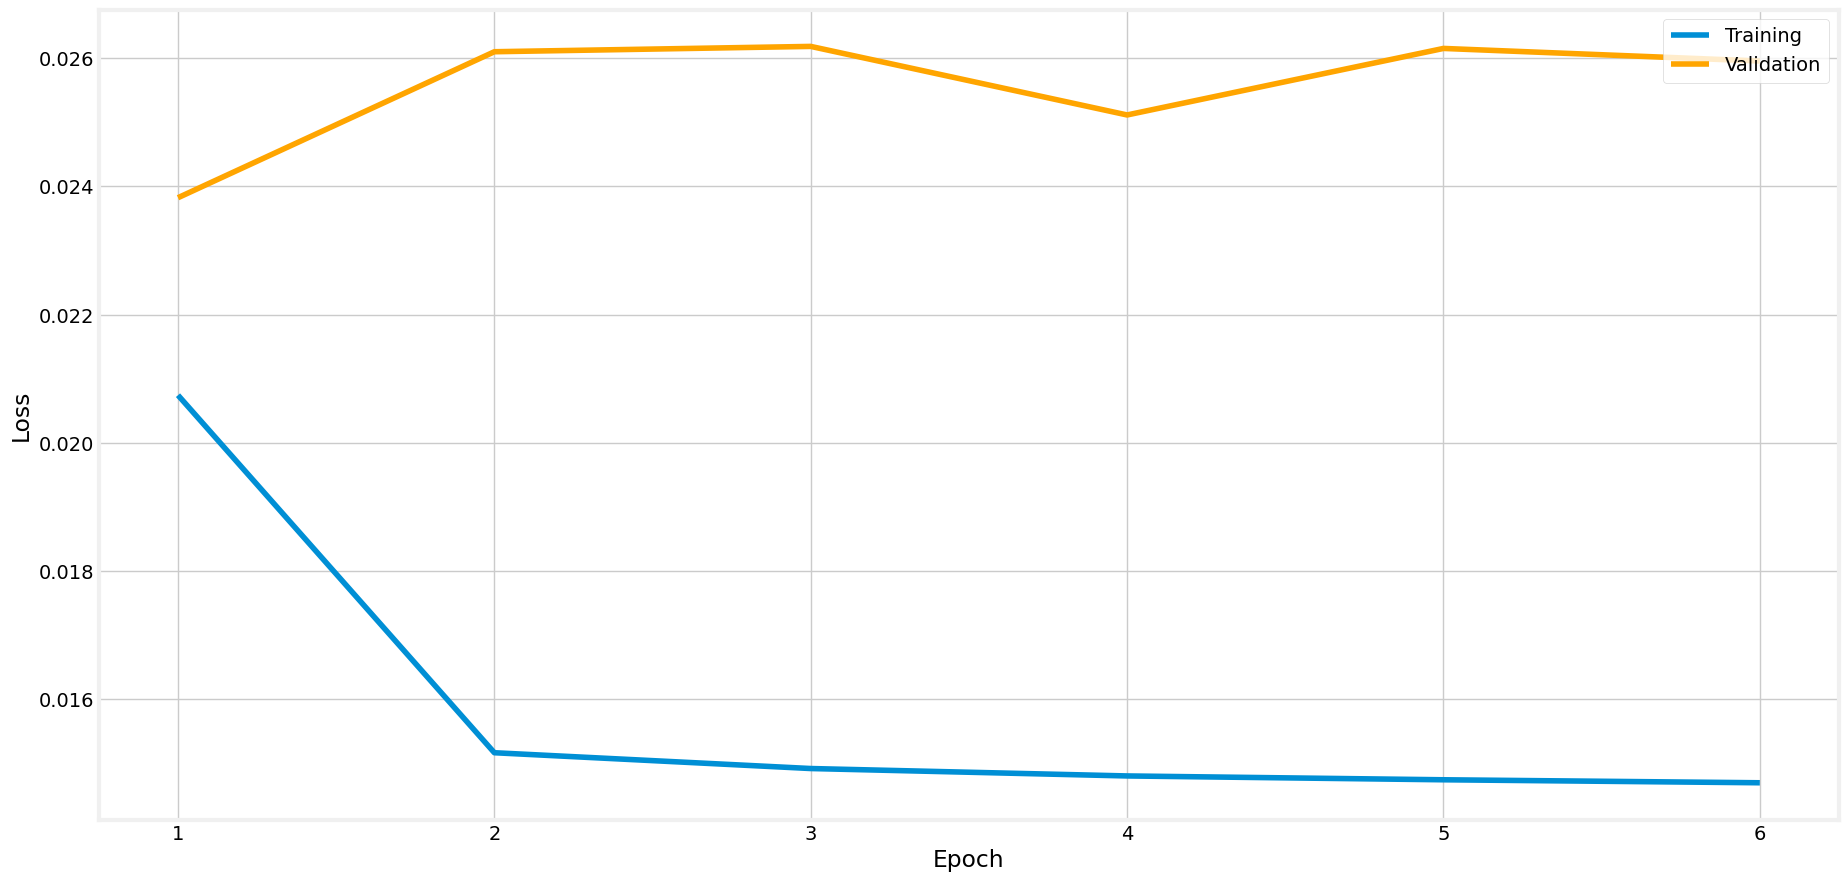

In [89]:
training(model)

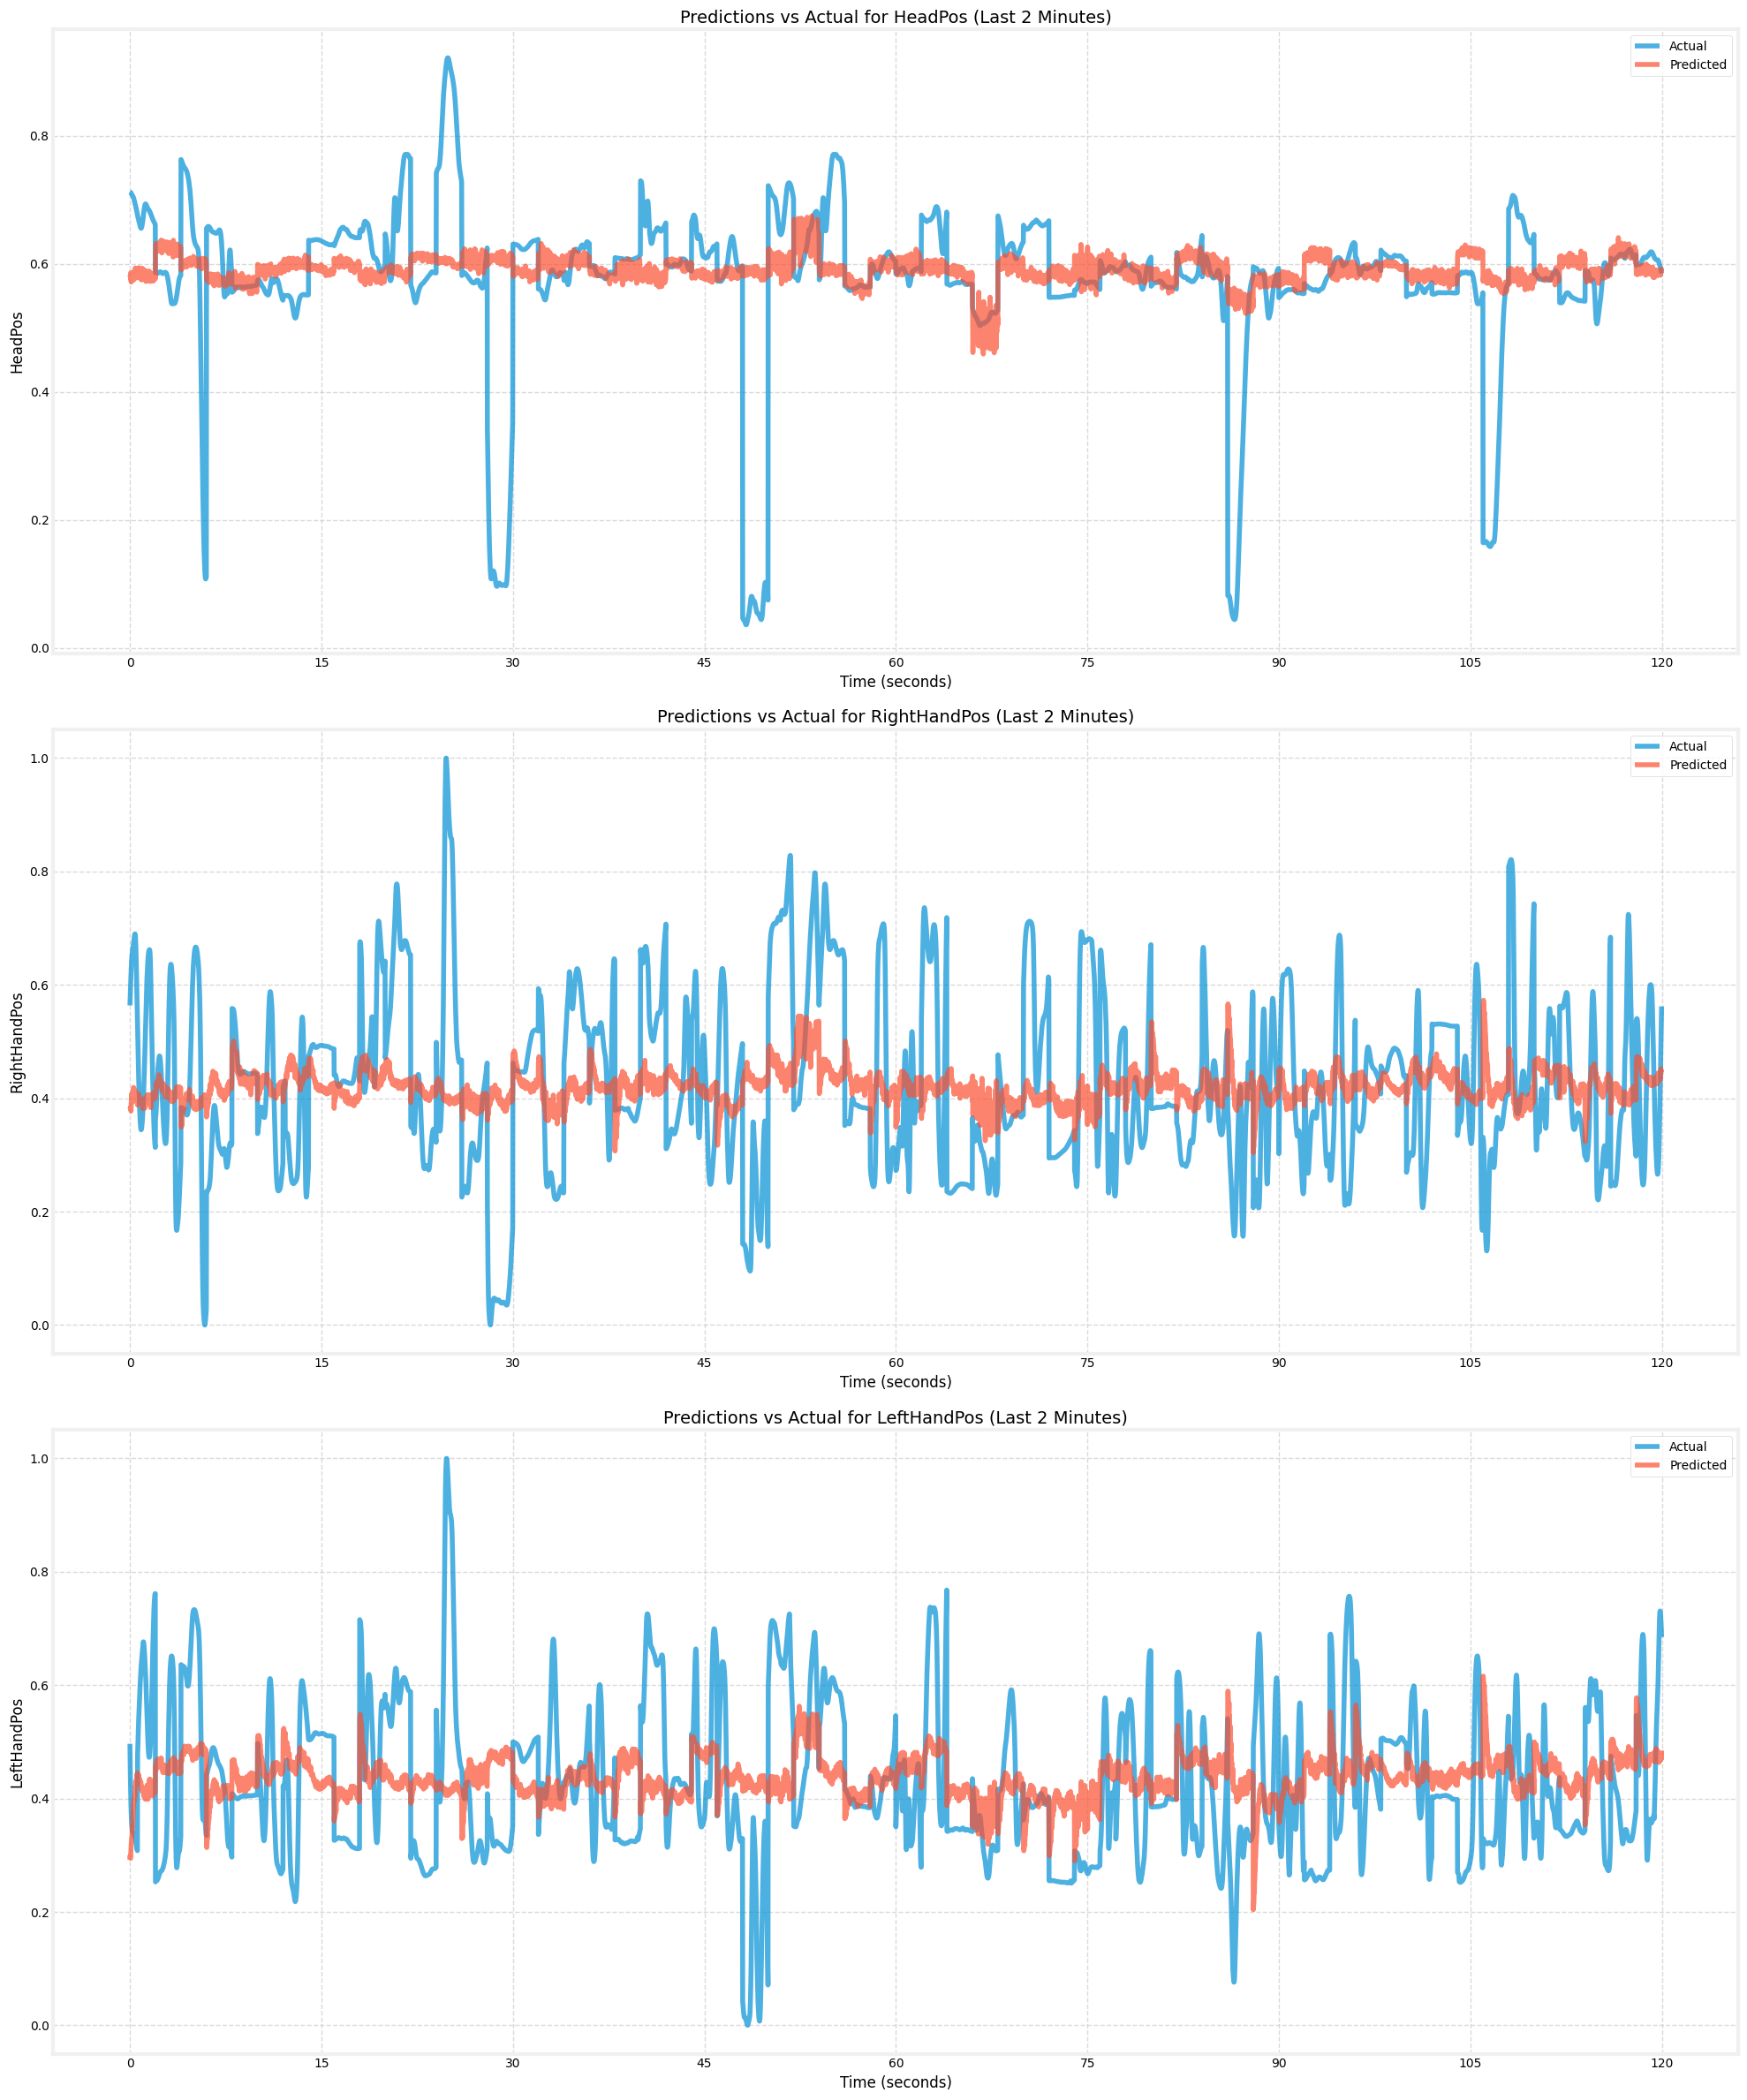

In [90]:
plot_predictions_over_time(model, device, train_loader, Labels)

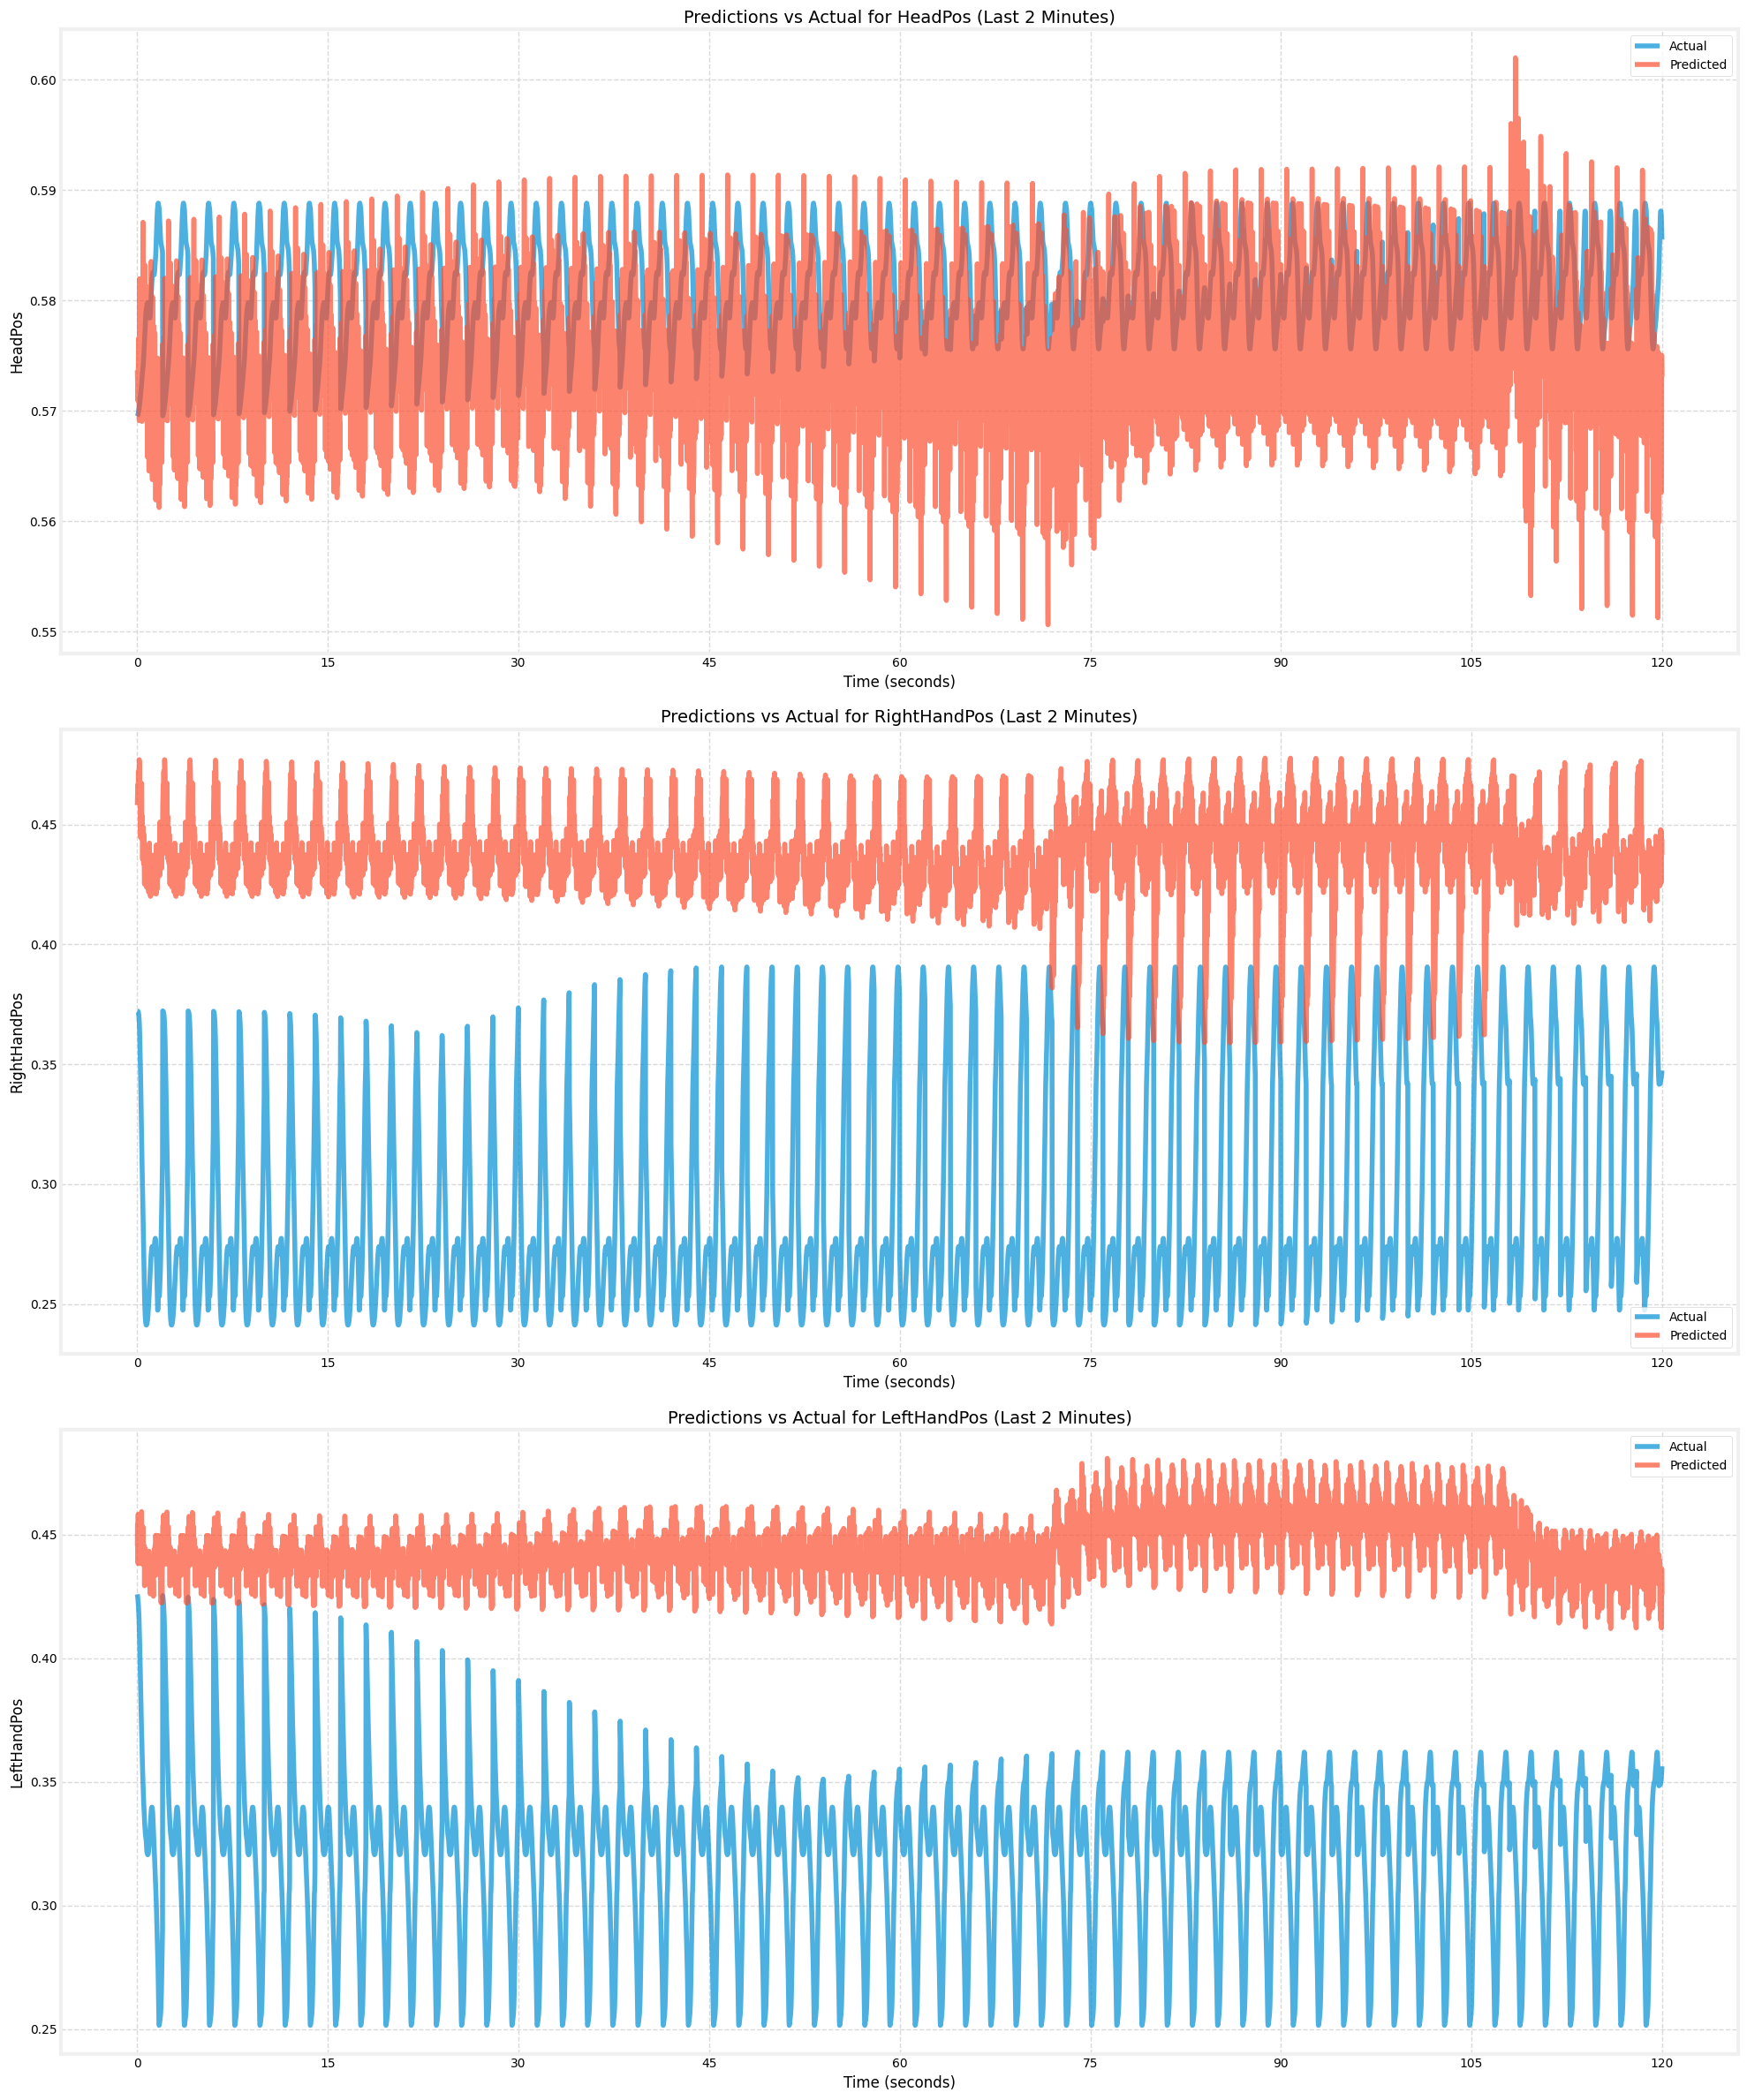

In [91]:
plot_predictions_over_time(model, device, test_loader, Labels)

### V.2. Long short-term memory (LSTM)

In [92]:
class ModelLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, forecast_horizon):
        super(ModelLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * forecast_horizon)
        self.forecast_horizon = forecast_horizon
        self.output_size = output_size

    def forward(self, x):
        lstm_out, _ = self.lstm1(x)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        return output.view(-1, self.forecast_horizon, self.output_size)

In [93]:
model = ModelLSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, FORECAST_HORIZON).to(device)

Training on cuda


  0%|          | 0/20 [00:00<?, ?it/s]

>>> Epoch: 5
Training set: Average loss: 0.014345
Validation set: Average loss: 0.025087
╒══════════════╤══════════════════════╕
│ Label        │   Mean Squared Error │
╞══════════════╪══════════════════════╡
│ HeadPos      │            0.0191919 │
├──────────────┼──────────────────────┤
│ RightHandPos │            0.0330091 │
├──────────────┼──────────────────────┤
│ LeftHandPos  │            0.0230732 │
╘══════════════╧══════════════════════╛
Stopping training due to no improvement in validation loss.


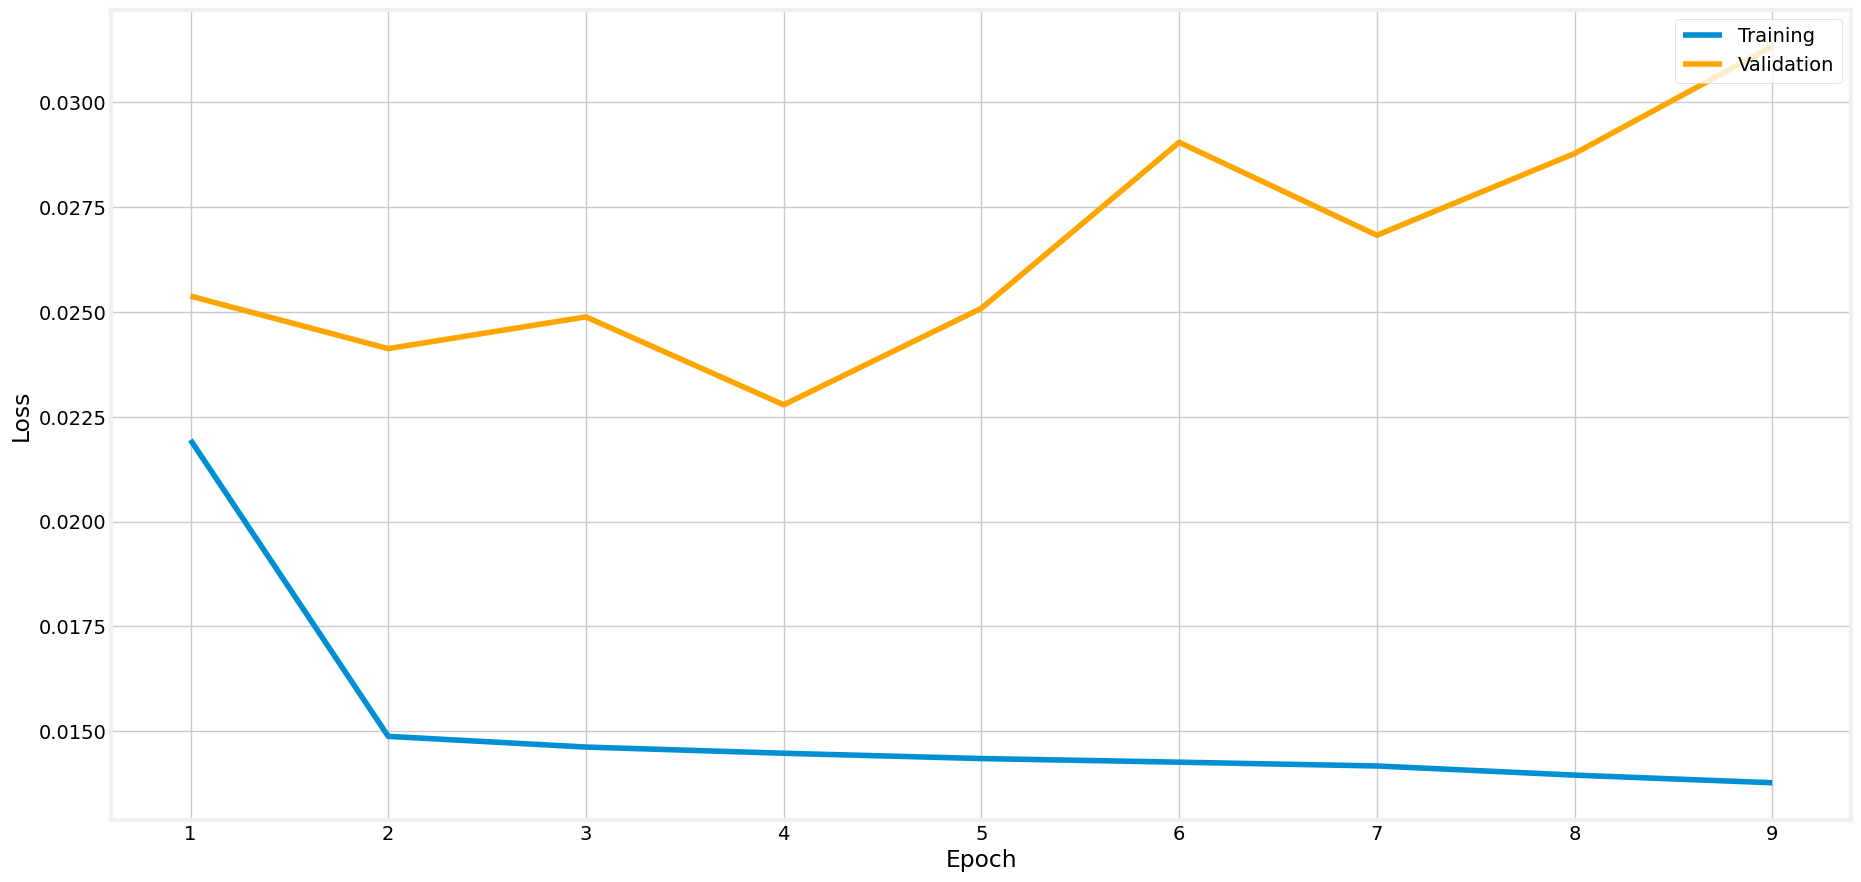

In [94]:
training(model)

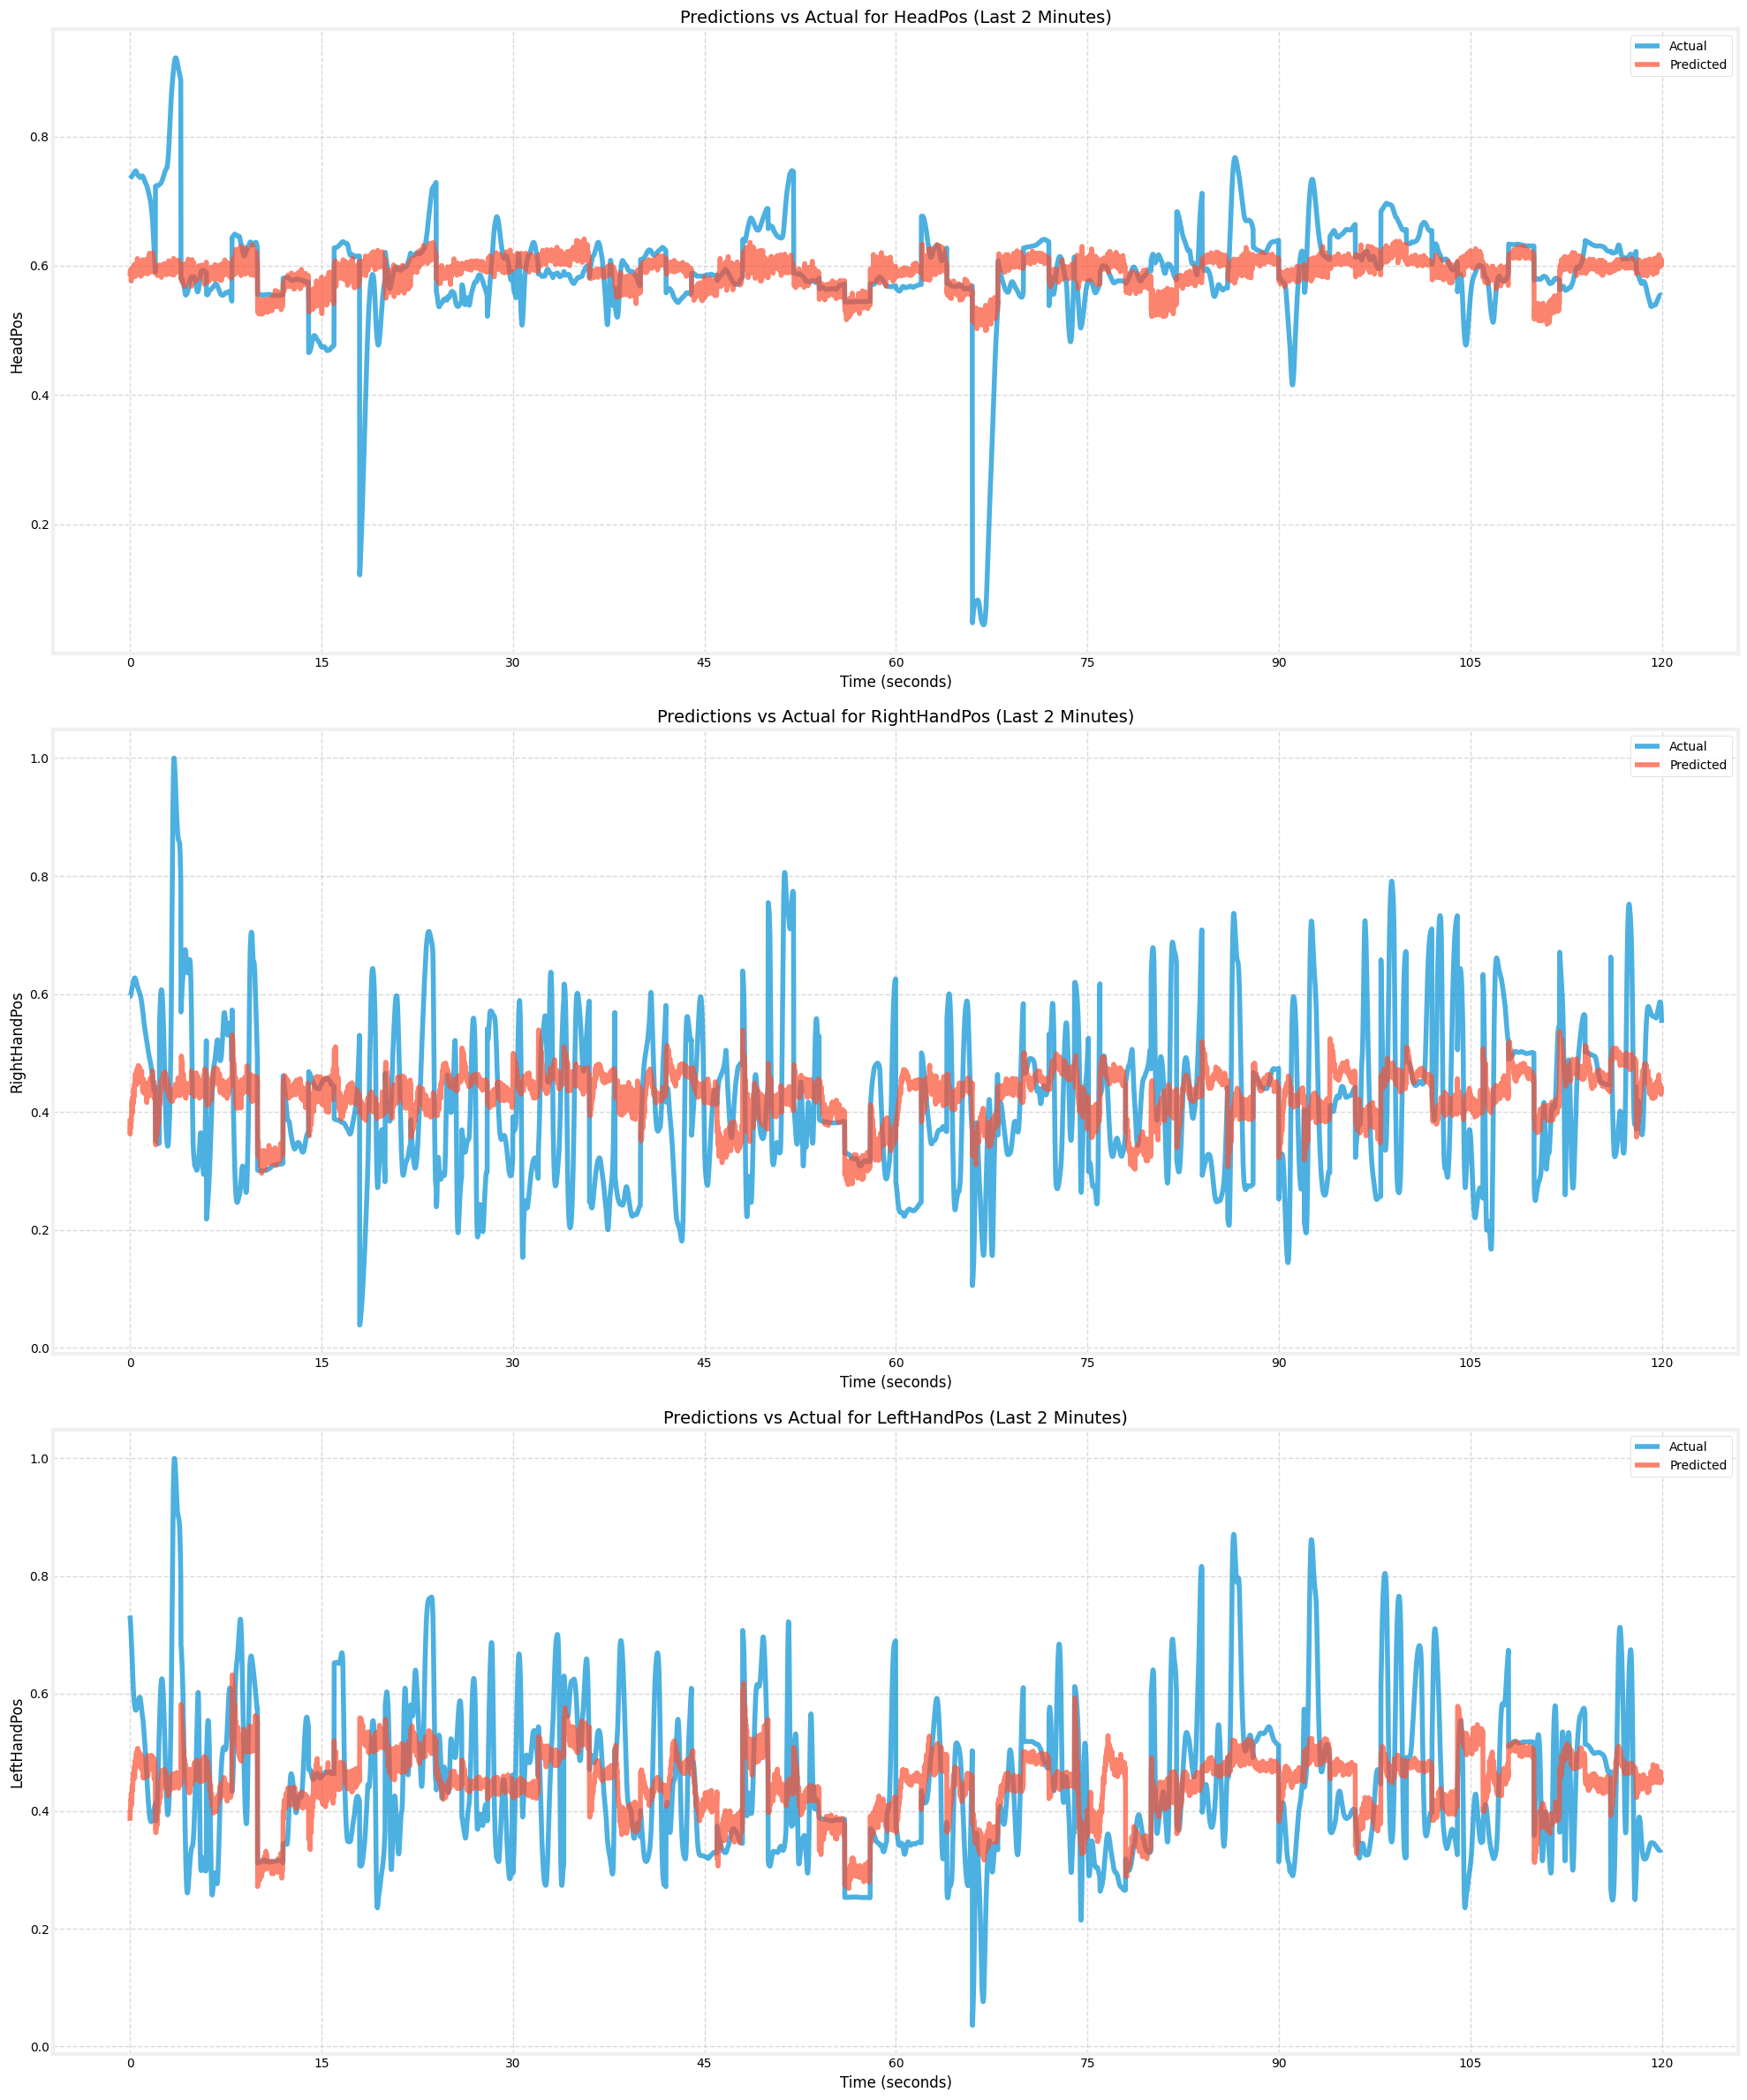

In [95]:
plot_predictions_over_time(model, device, train_loader, Labels)

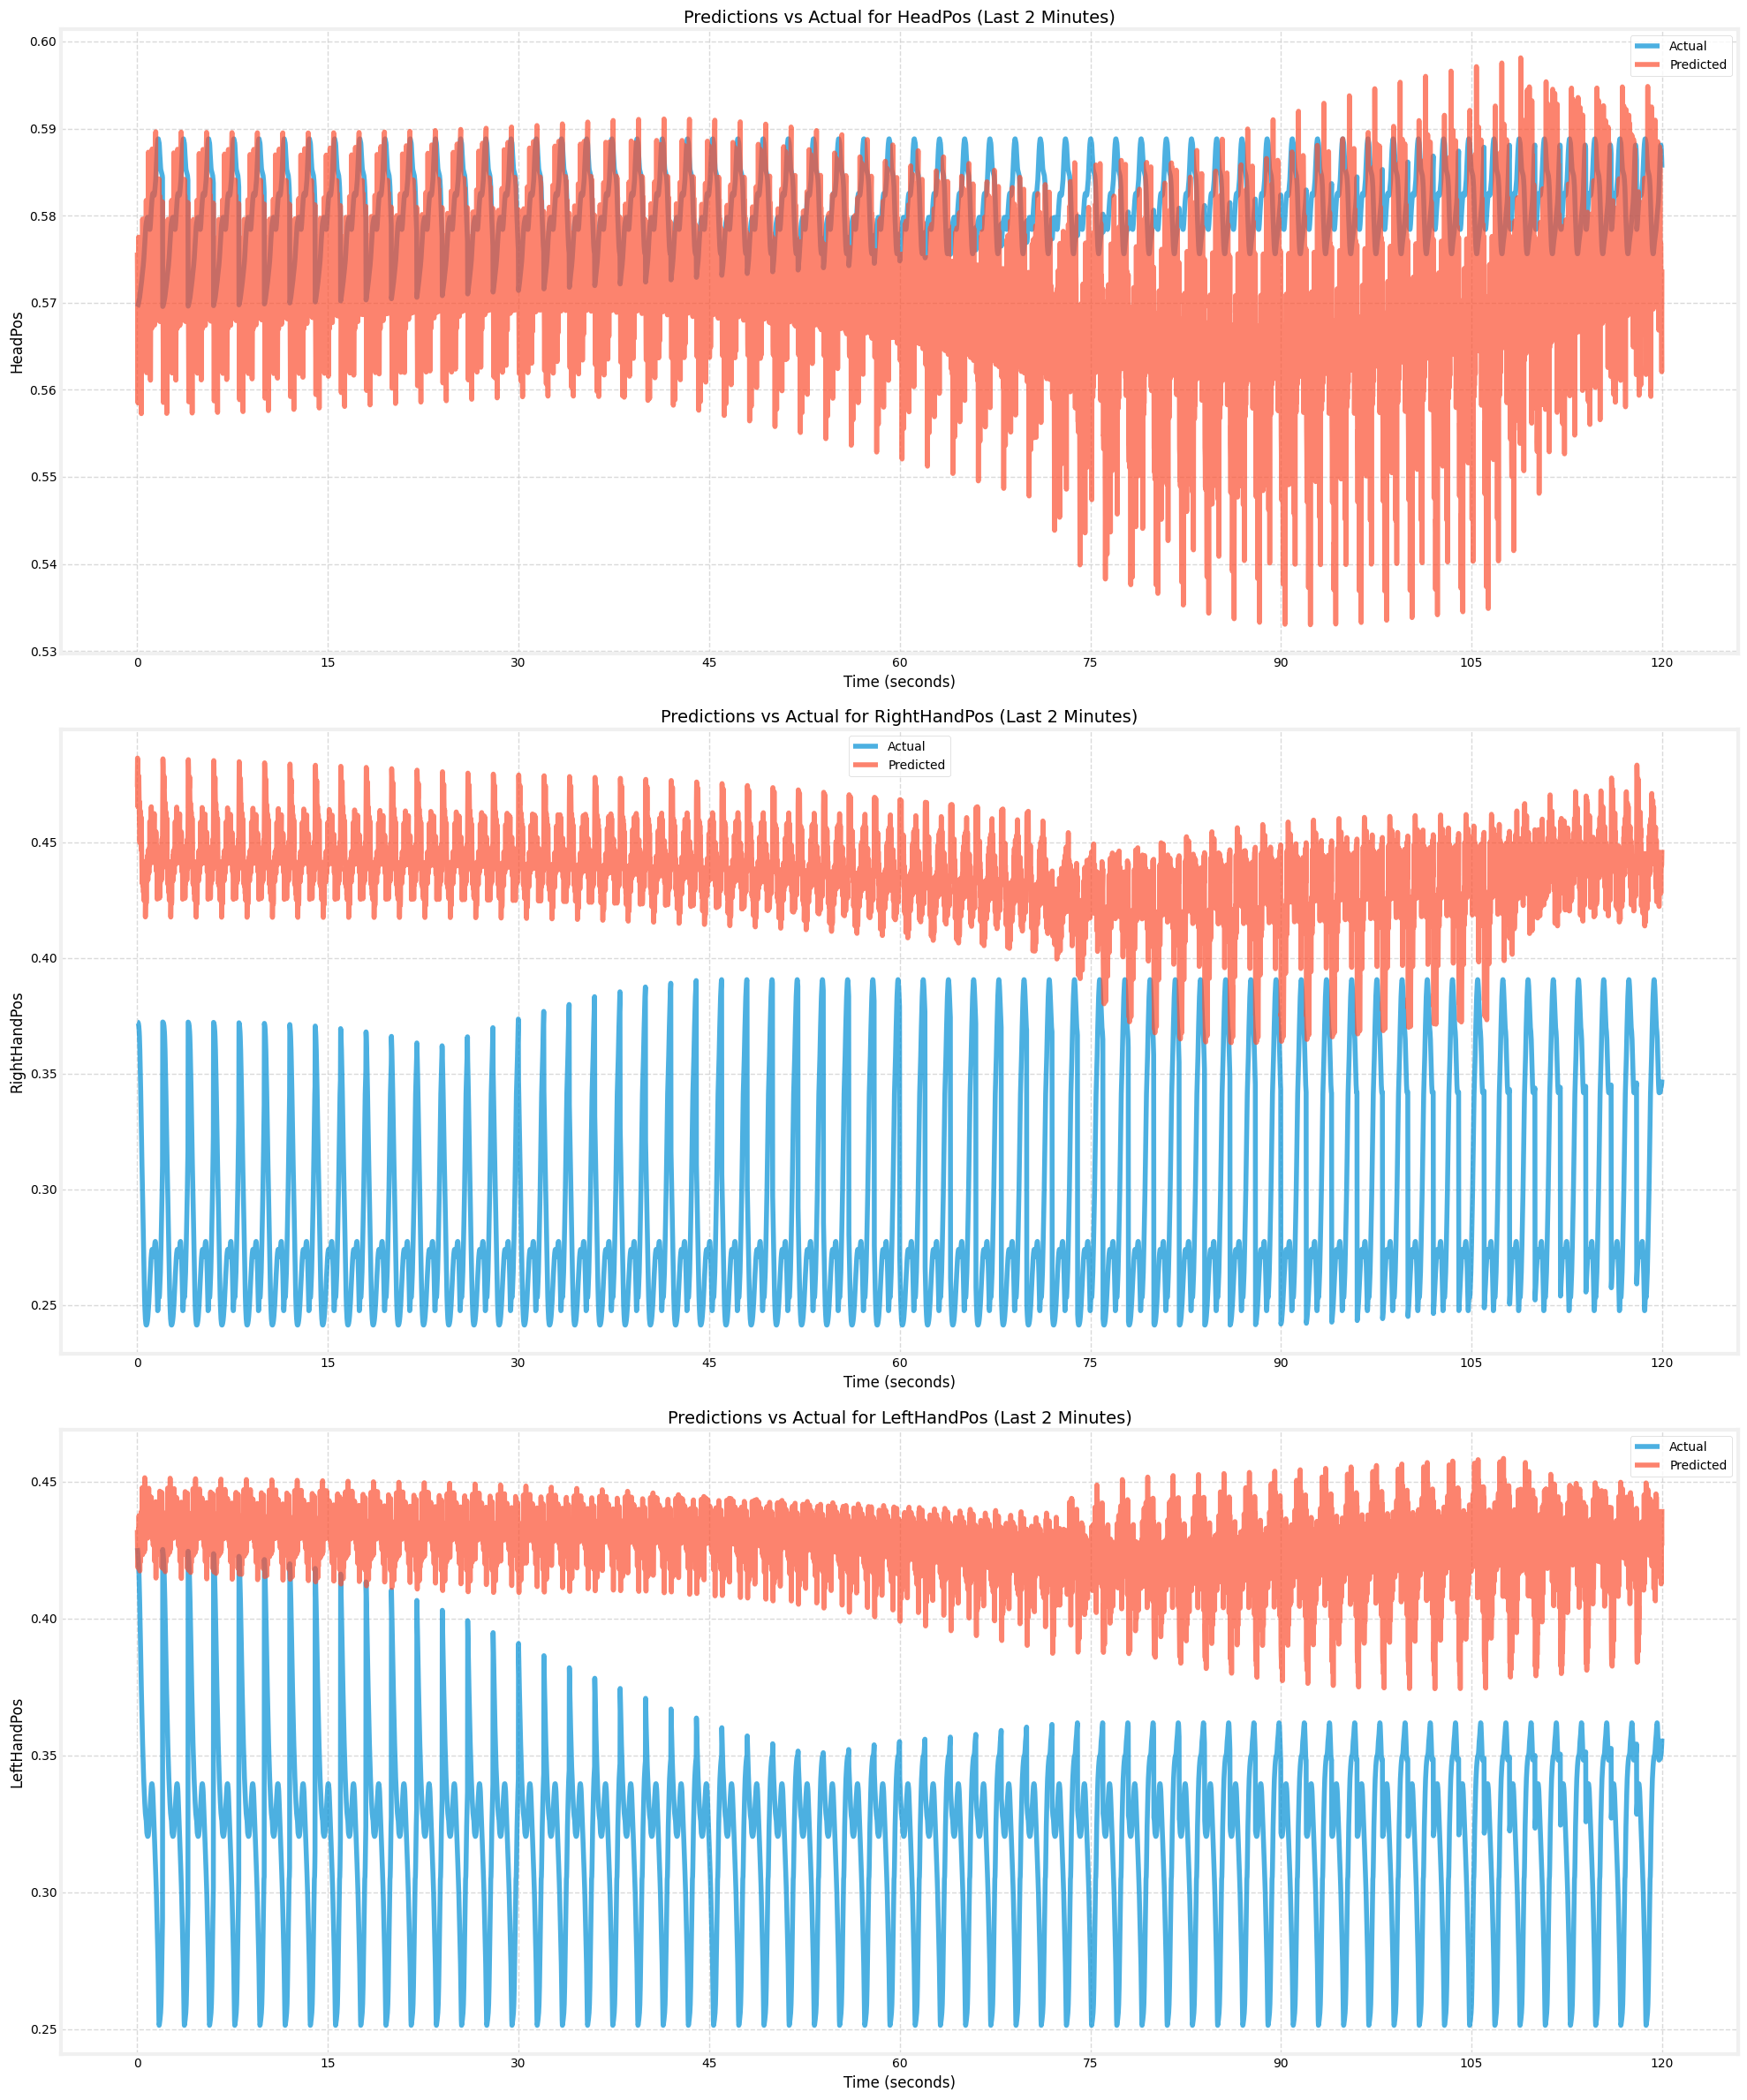

In [96]:
plot_predictions_over_time(model, device, test_loader, Labels)

### V.3. Gated Recurrent Unit (GRU)

In [97]:
class ModelGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, forecast_horizon):
        super(ModelGRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * forecast_horizon)
        self.forecast_horizon = forecast_horizon
        self.output_size = output_size

    def forward(self, x):
        gru_out, _ = self.gru1(x)
        gru_out = gru_out[:, -1, :]
        output = self.fc(gru_out)
        return output.view(-1, self.forecast_horizon, self.output_size)

In [98]:
model = ModelGRU(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, FORECAST_HORIZON).to(device)

Training on cuda


  0%|          | 0/20 [00:00<?, ?it/s]

>>> Epoch: 5
Training set: Average loss: 0.014056
Validation set: Average loss: 0.027759
╒══════════════╤══════════════════════╕
│ Label        │   Mean Squared Error │
╞══════════════╪══════════════════════╡
│ HeadPos      │            0.0218085 │
├──────────────┼──────────────────────┤
│ RightHandPos │            0.0357462 │
├──────────────┼──────────────────────┤
│ LeftHandPos  │            0.0257364 │
╘══════════════╧══════════════════════╛
Stopping training due to no improvement in validation loss.


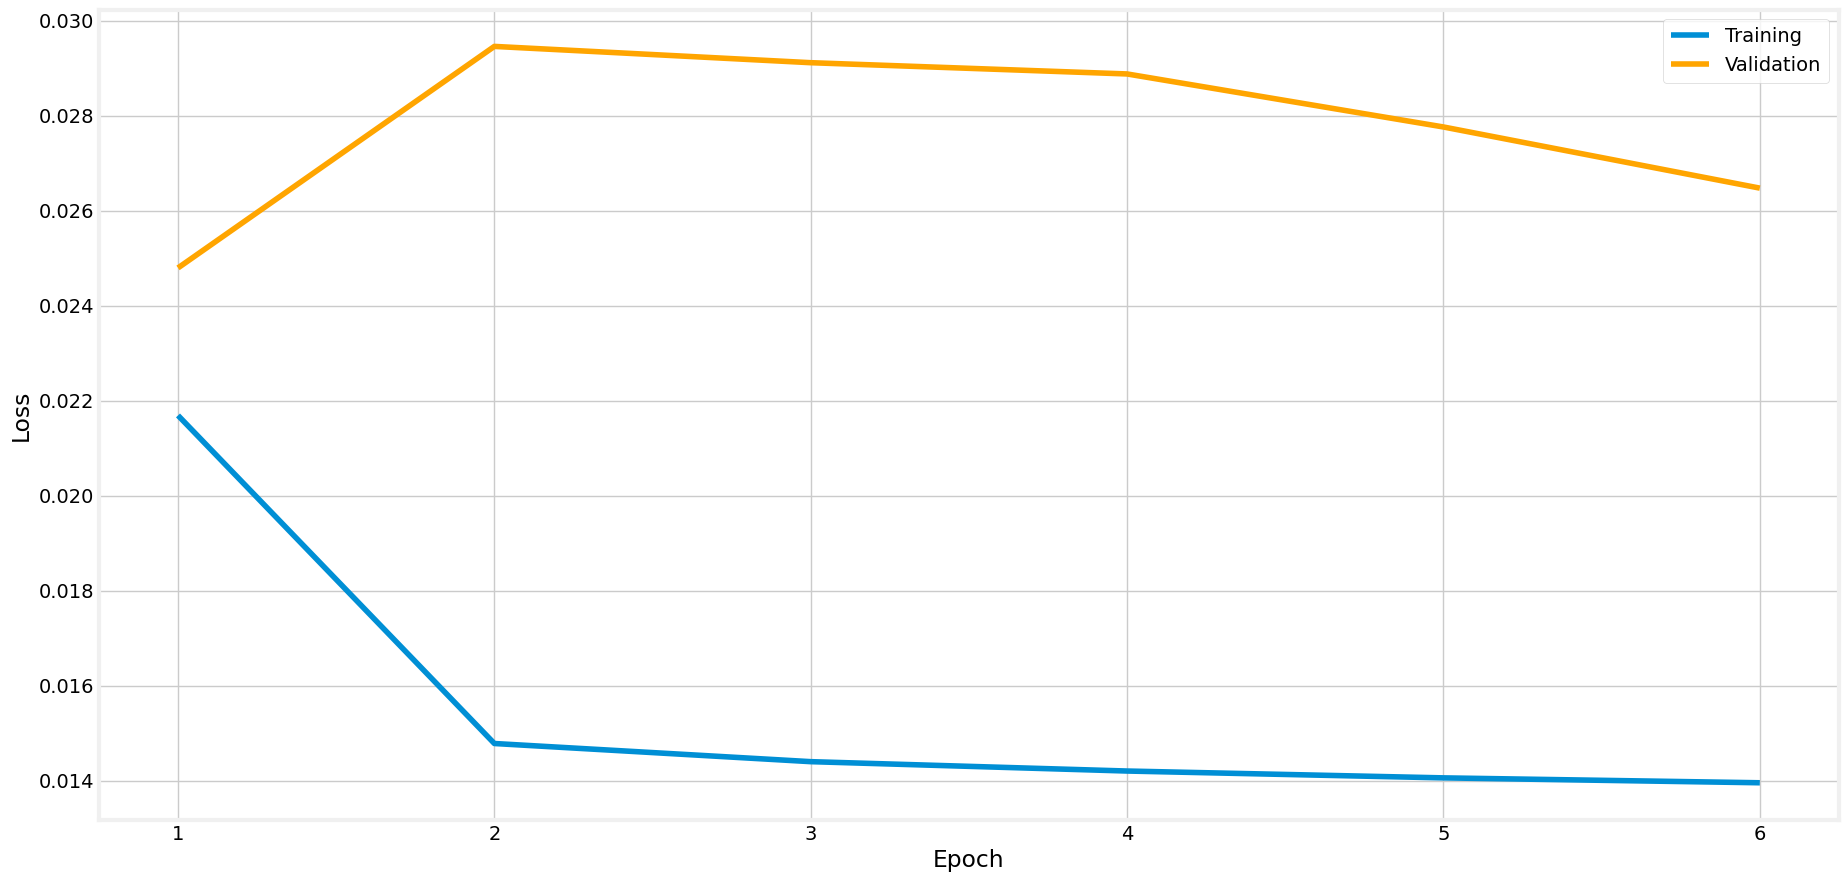

In [99]:
training(model)

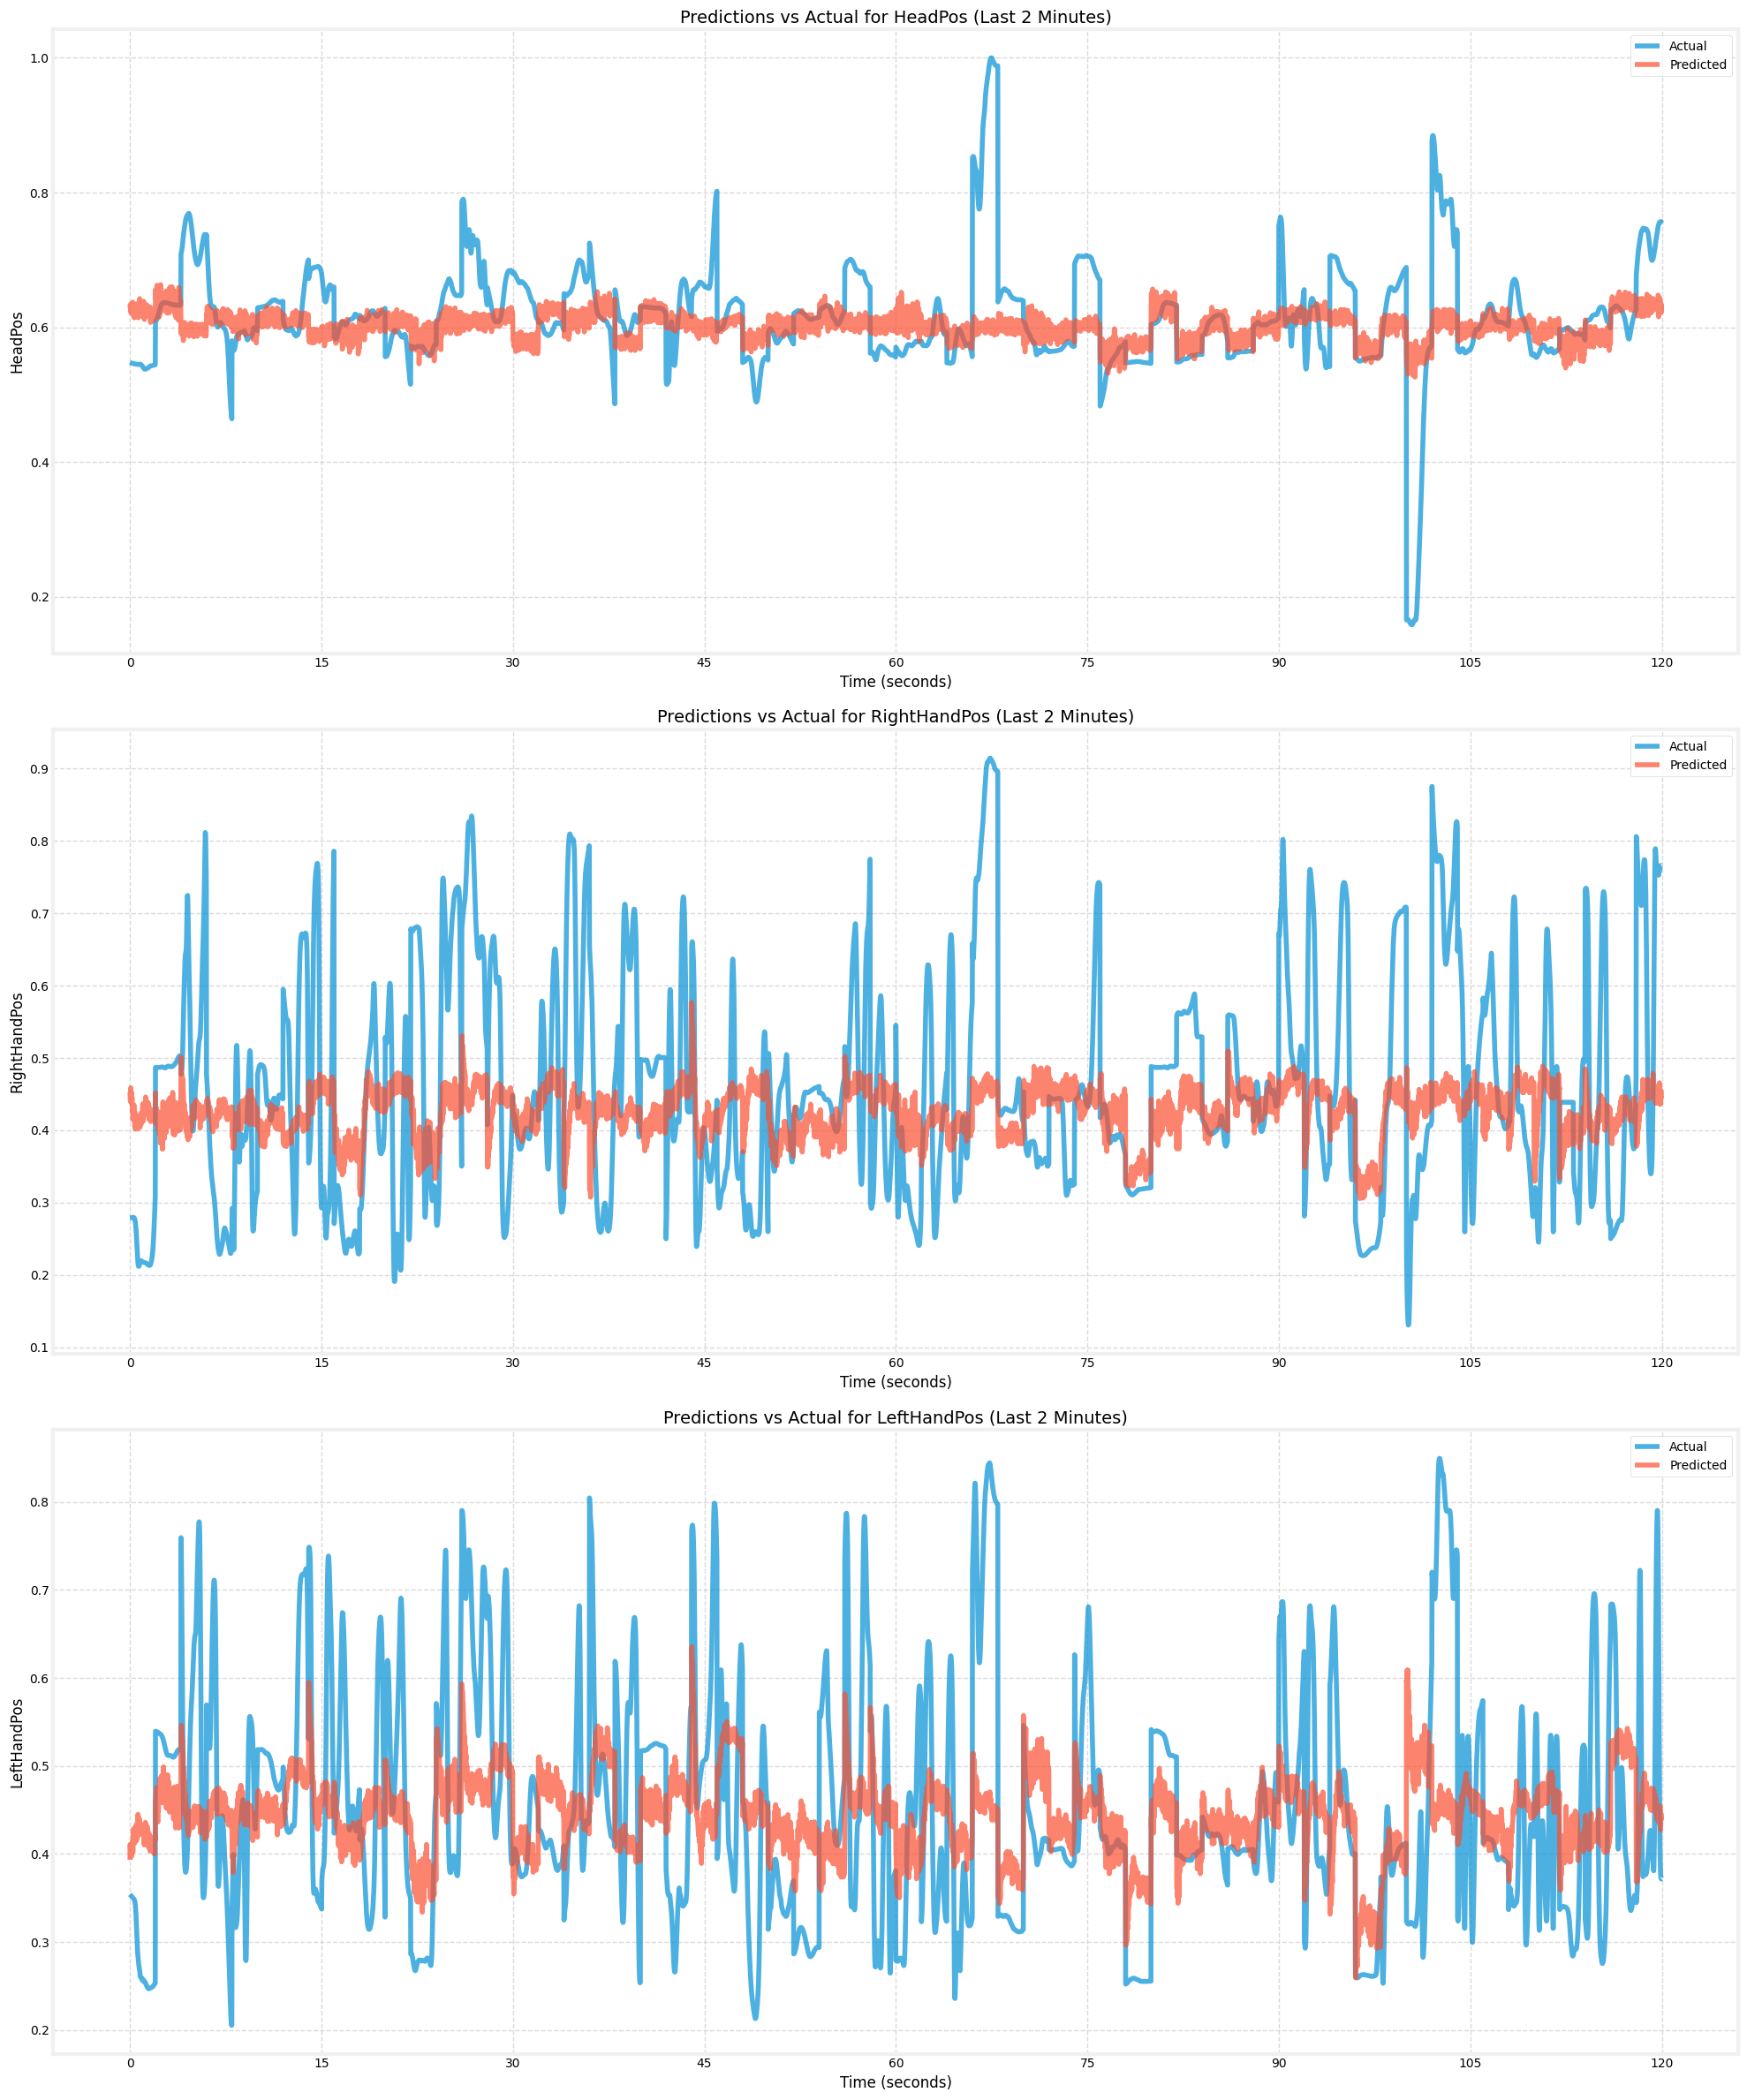

In [100]:
plot_predictions_over_time(model, device, train_loader, Labels)

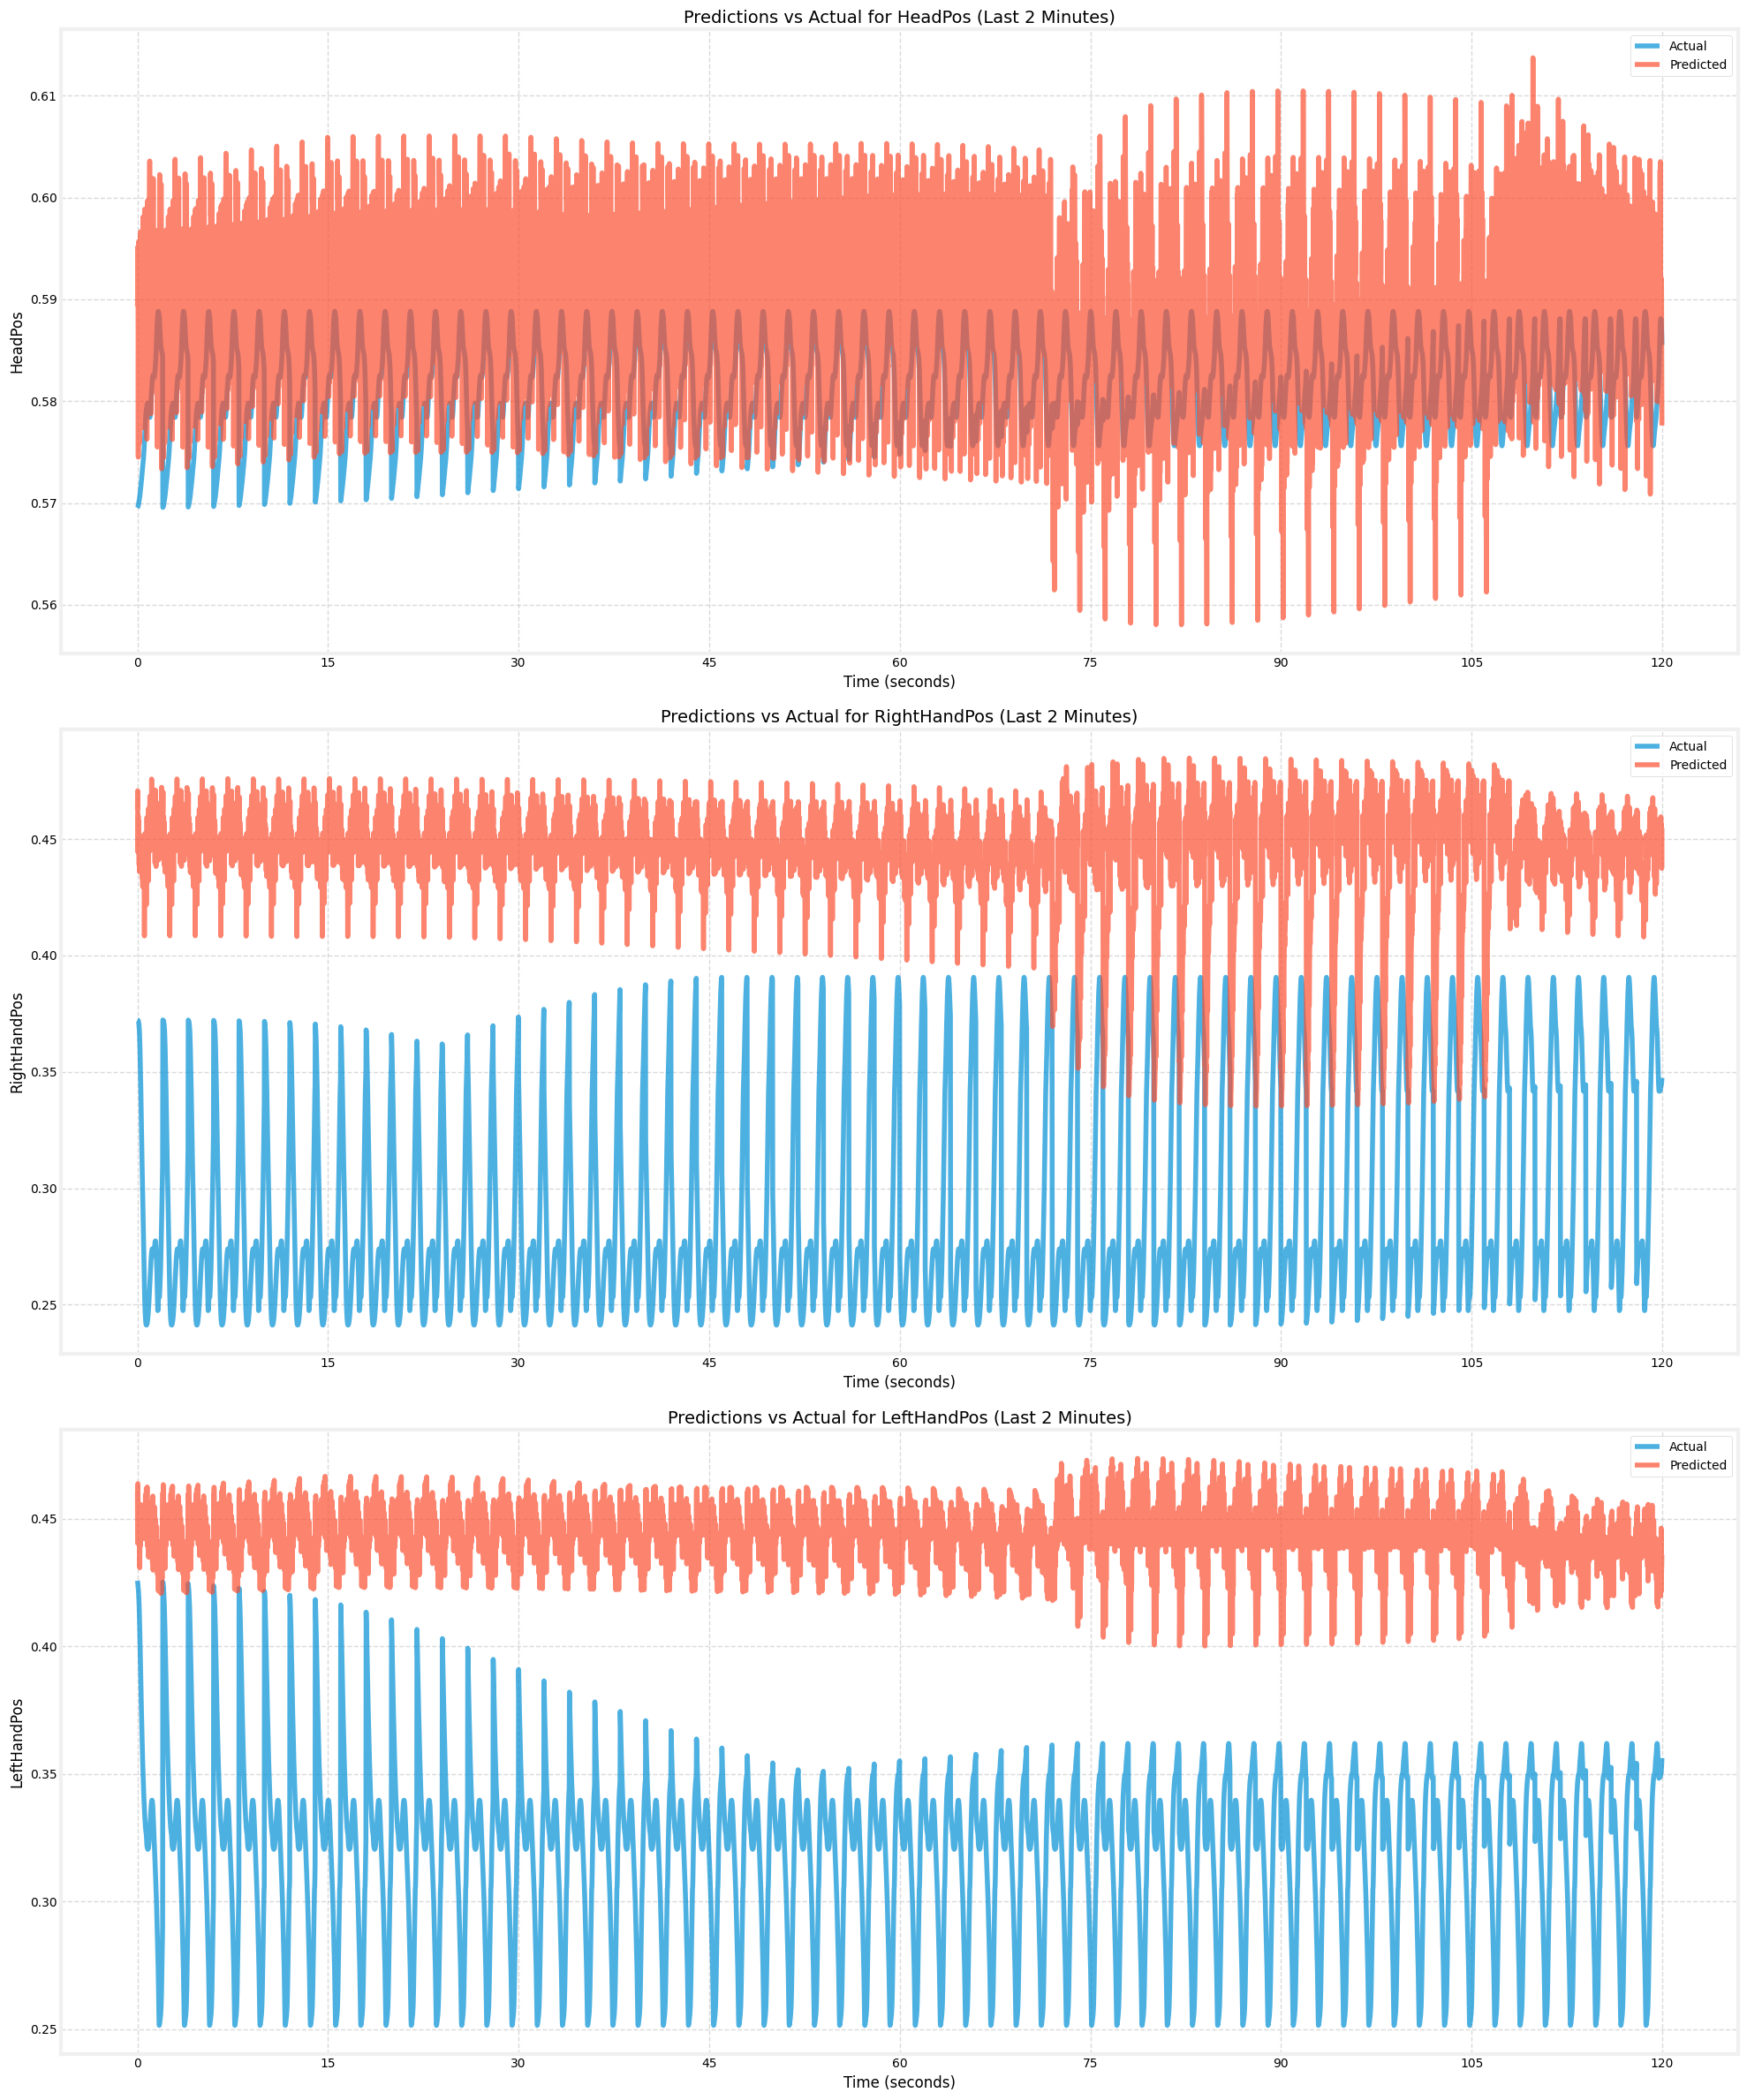

In [101]:
plot_predictions_over_time(model, device, test_loader, Labels)

### V.4. Convolutional Neural Networks (CNN)

In [102]:
class ModelCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, forecast_horizon, window_size):
        super(ModelCNN, self).__init__()
        self.hidden_size = hidden_size
        self.forecast_horizon = forecast_horizon
        self.output_size = output_size

        # Convolutional layers
        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=1)
        
        # Max pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Calculate the size of the flattened output after convolutions and pooling
        self.flatten_size = hidden_size * (window_size // 4)  # Divided by 4 due to two pooling layers

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size * forecast_horizon)

    def forward(self, x):
        # Apply the first convolutional layer
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        
        # Apply the second convolutional layer
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)

        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = torch.relu(x)
        output = self.fc2(x)
        return output.view(-1, self.forecast_horizon, self.output_size)

In [104]:
model = ModelCNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, FORECAST_HORIZON, WINDOW_SIZE).to(device)

Training on cuda


  0%|          | 0/20 [00:00<?, ?it/s]

>>> Epoch: 5
Training set: Average loss: 0.007394
Validation set: Average loss: 0.030559
╒══════════════╤══════════════════════╕
│ Label        │   Mean Squared Error │
╞══════════════╪══════════════════════╡
│ HeadPos      │            0.0194809 │
├──────────────┼──────────────────────┤
│ RightHandPos │            0.0421009 │
├──────────────┼──────────────────────┤
│ LeftHandPos  │            0.0300014 │
╘══════════════╧══════════════════════╛
Stopping training due to no improvement in validation loss.


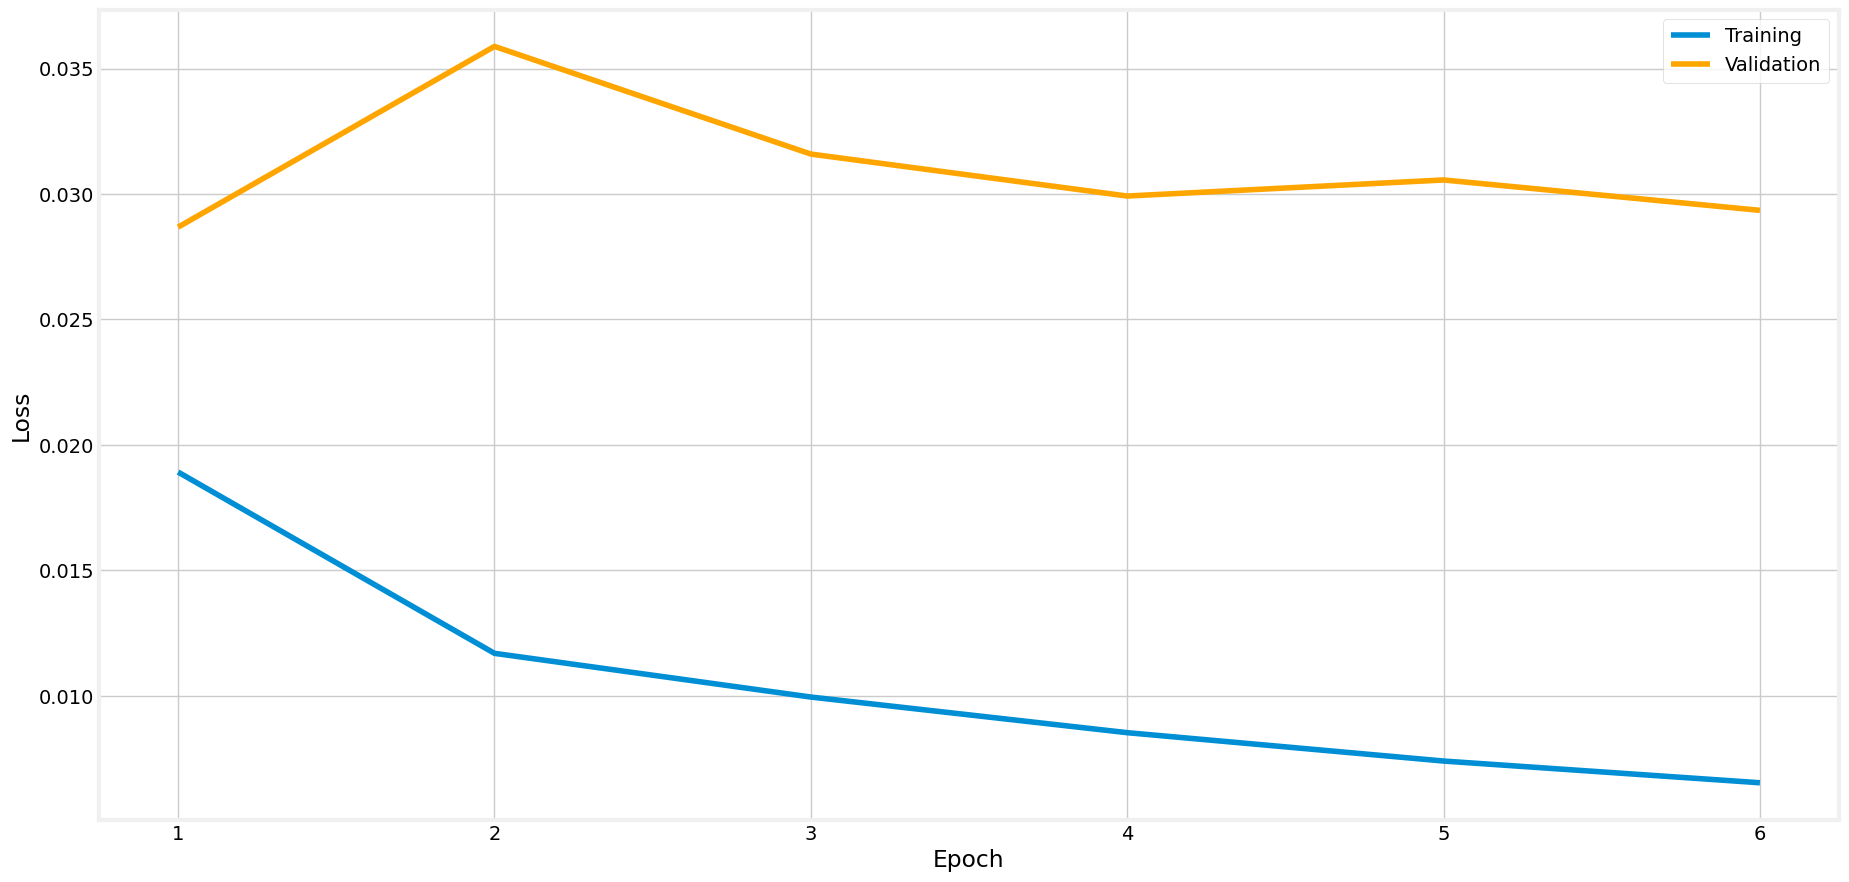

In [105]:
training(model)

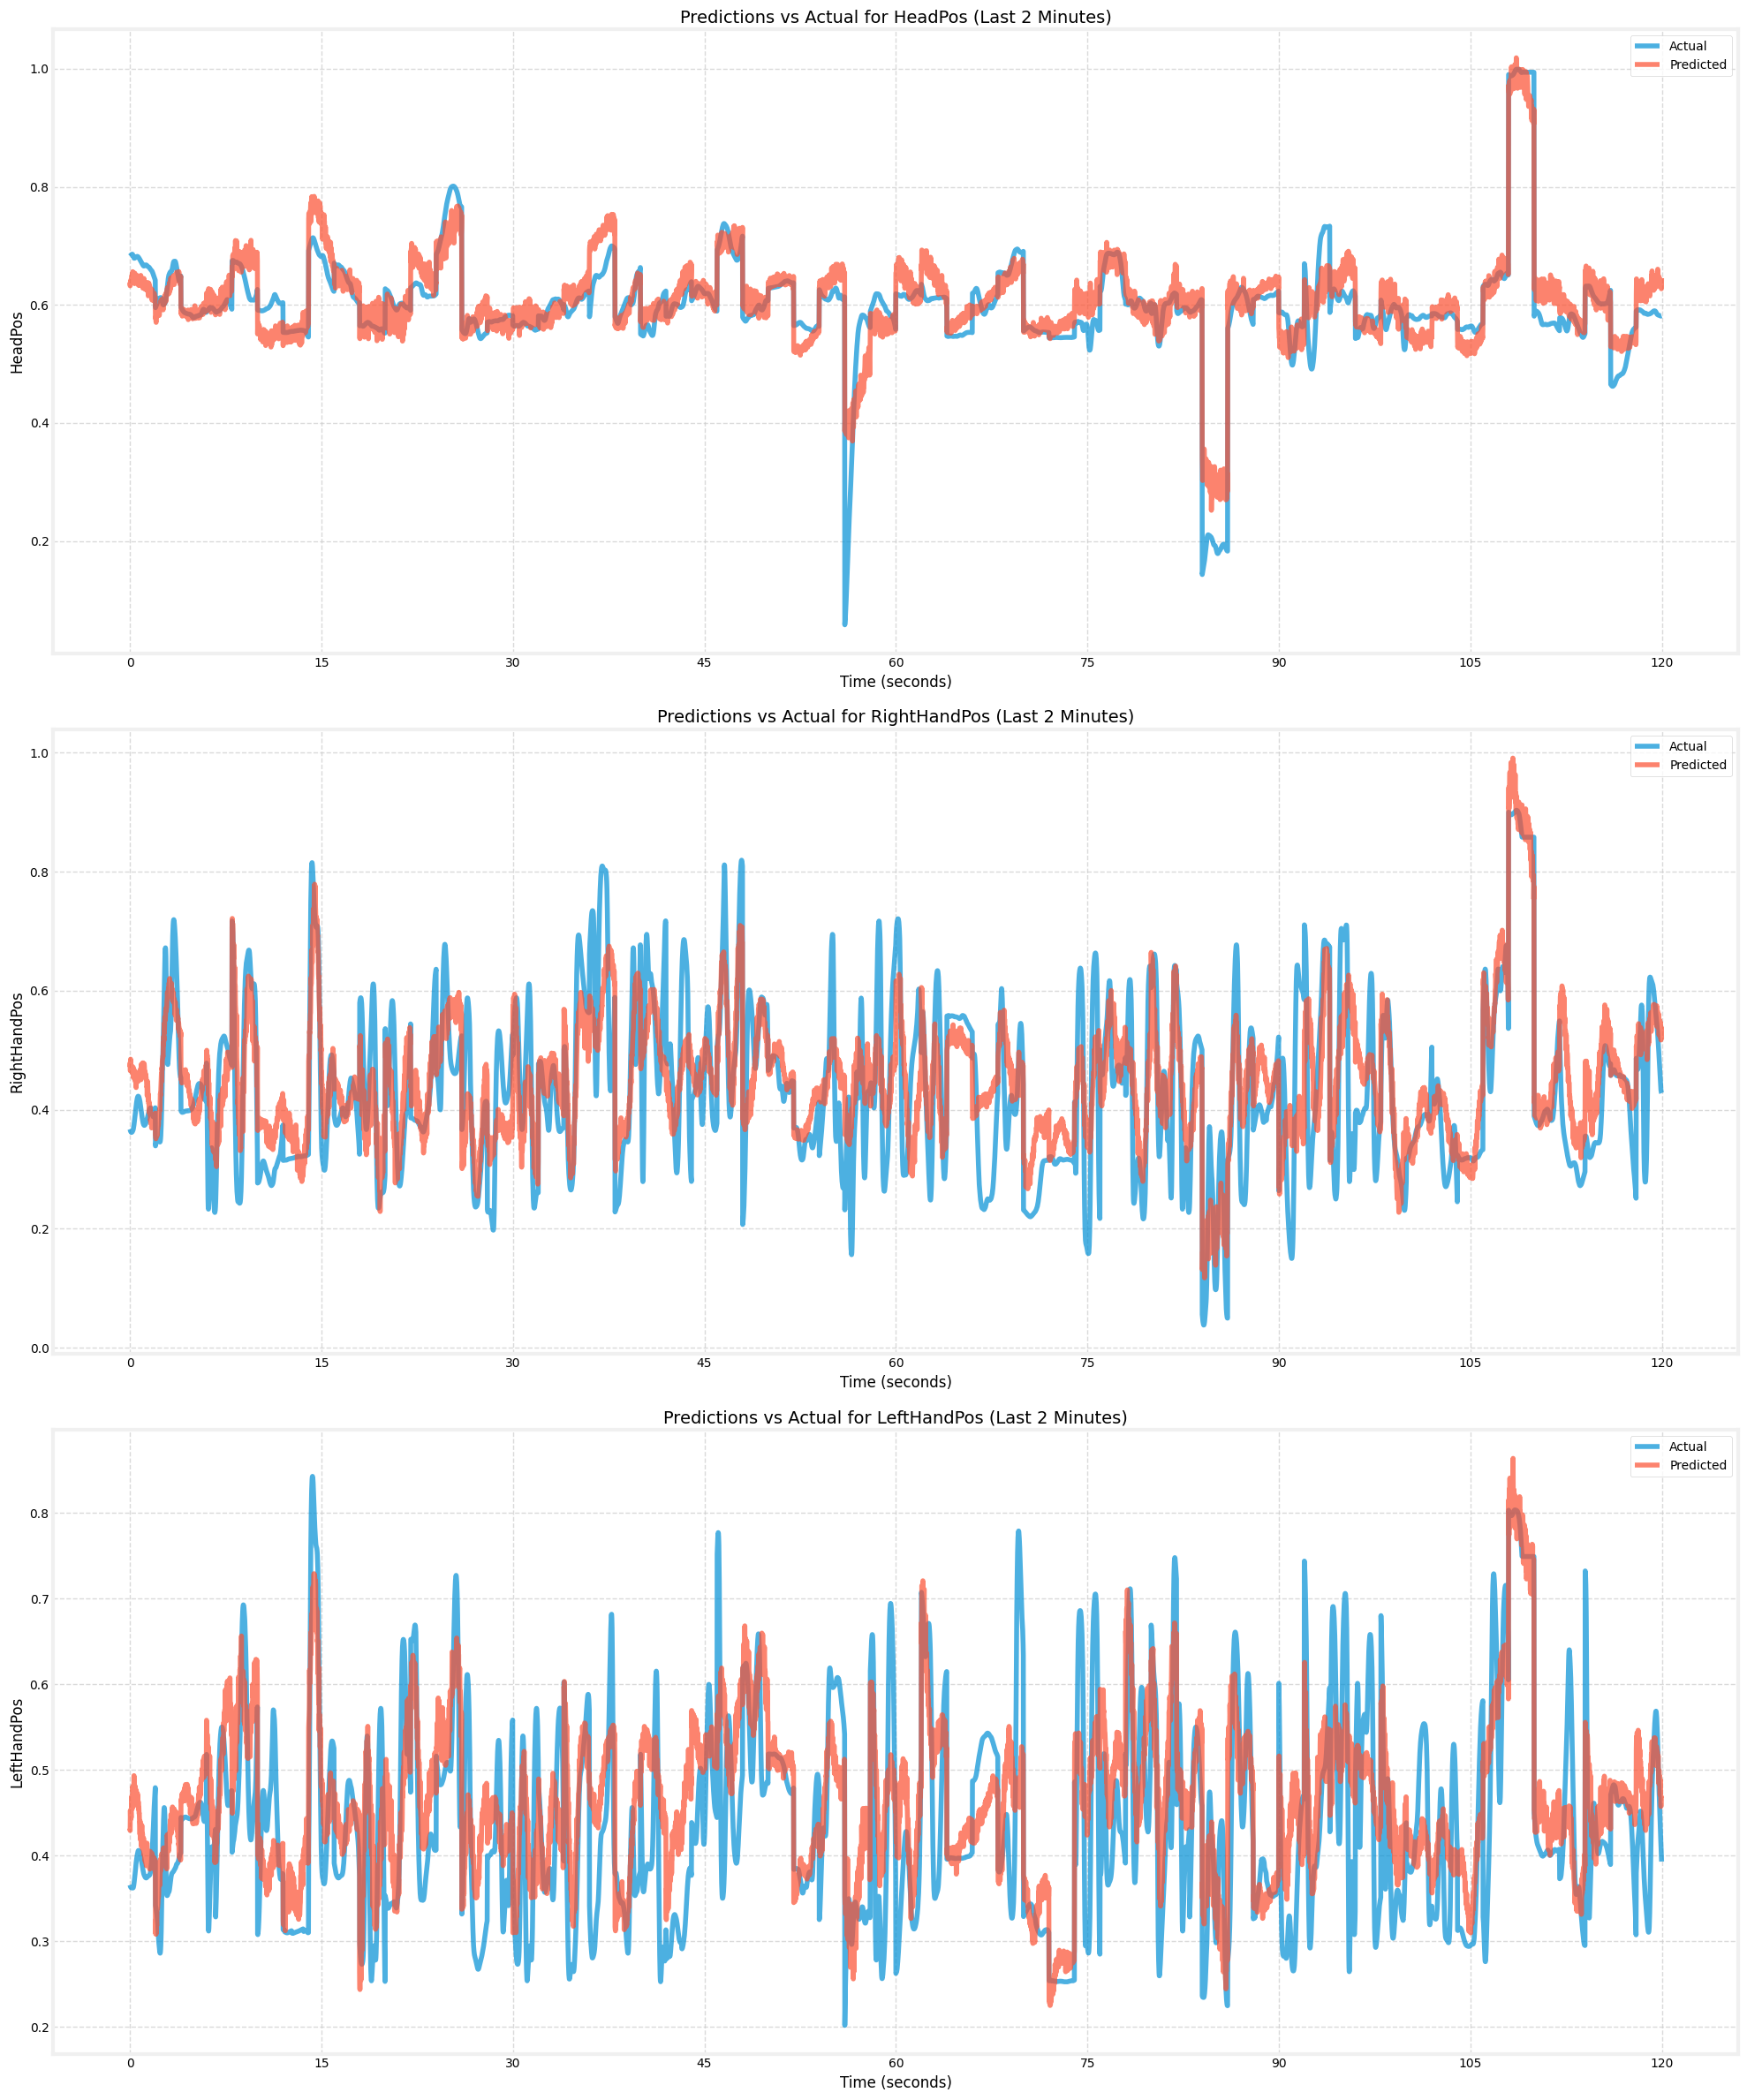

In [106]:
plot_predictions_over_time(model, device, train_loader, Labels)

In [ ]:
plot_predictions_over_time(model, device, test_loader, Labels)